In [3]:
import pathlib
import scipy.io as sio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg



# Read the real data

In [4]:
data_file = 'Bz_uc0.mat'
data_dir = pathlib.Path("..") / "data" / data_file

mat_contents = sio.loadmat(data_dir)
print(mat_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Bt', 'Bz', 'corners', 'h', 'newLED', 'step'])


In [5]:
step = mat_contents['step'] * 1.0E6                  # grid spacing (µm)
shape = np.shape(mat_contents['Bz'])                 # grid shape
data = mat_contents['Bz'] *1.0E9                     # 2D Bz data (nT)
sensor_sample_distance = mat_contents['h'] * 1.0E6   # sensor-sample distance (µm)

print('Sensor sample distance = %s µm'%float(sensor_sample_distance))
print('step = %s µm'%float(step))
print('data shape =', shape)

Sensor sample distance = 5.0 µm
step = 2.35 µm
data shape = (600, 960)


Now, we create a regular grid of observation points.

In [6]:
x_max = int(shape[0]*step)
y_max = int(shape[1]*step)


coordinates = vd.grid_coordinates(
    region=[0, y_max-2.35, 0, x_max-2.35],  # µm
#     shape=shape,
    spacing=float(step),# µm
    extra_coords=sensor_sample_distance,
)


print(coordinates[0])
print(np.shape(coordinates))
print((coordinates))


[[   0.      2.35    4.7  ... 2248.95 2251.3  2253.65]
 [   0.      2.35    4.7  ... 2248.95 2251.3  2253.65]
 [   0.      2.35    4.7  ... 2248.95 2251.3  2253.65]
 ...
 [   0.      2.35    4.7  ... 2248.95 2251.3  2253.65]
 [   0.      2.35    4.7  ... 2248.95 2251.3  2253.65]
 [   0.      2.35    4.7  ... 2248.95 2251.3  2253.65]]
(3, 600, 960)
(array([[   0.  ,    2.35,    4.7 , ..., 2248.95, 2251.3 , 2253.65],
       [   0.  ,    2.35,    4.7 , ..., 2248.95, 2251.3 , 2253.65],
       [   0.  ,    2.35,    4.7 , ..., 2248.95, 2251.3 , 2253.65],
       ...,
       [   0.  ,    2.35,    4.7 , ..., 2248.95, 2251.3 , 2253.65],
       [   0.  ,    2.35,    4.7 , ..., 2248.95, 2251.3 , 2253.65],
       [   0.  ,    2.35,    4.7 , ..., 2248.95, 2251.3 , 2253.65]]), array([[   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   2.35,    2.35,    2.35, ...,    2.35,    2.35,    2.35],
       [   4.7 ,    4.7 ,    4.7 , ...,    4.7 ,    4.7 ,    4.7 ],
       ...,
       [140

In [7]:
data = vd.make_xarray_grid(coordinates, data, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 352.4 94.89 41.62 288.4 ... -4.196 -53.56 2.103

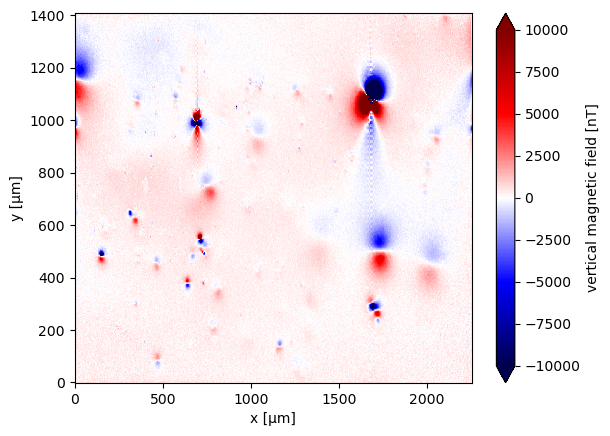

In [8]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Polynomial fitting to suppress high frequency noise
2. Upward continue the data to suppress high frequency noise
3. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
4. Contrast stretch the TGA to highlight weaker sources
5. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Polynomial fitting to suppress low frequency noise

In [9]:
trend = vd.Trend(degree=3).fit((coordinates), data.bz.values)
low_frequency_noise = trend.predict(coordinates).reshape(data.bz.shape)

data = data.assign(low_freq=(['y','x'],low_frequency_noise))
data.low_freq.attrs = {"long_name": "low-frequency noise", "units": "nT"}

residual = data.bz.values - data.low_freq.values
data = data.assign(residual=(['y','x'],residual))
data.residual.attrs = {"long_name": "residual anomaly", "units": "nT"}

data

<xarray.Dataset>
Dimensions:   (y: 600, x: 960)
Coordinates:
  * x         (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y         (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z         (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz        (y, x) float64 352.4 94.89 41.62 288.4 ... -4.196 -53.56 2.103
    low_freq  (y, x) float64 -158.8 -156.5 -154.1 -151.7 ... 506.6 508.7 510.8
    residual  (y, x) float64 511.2 251.3 195.7 440.1 ... -510.8 -562.2 -508.7

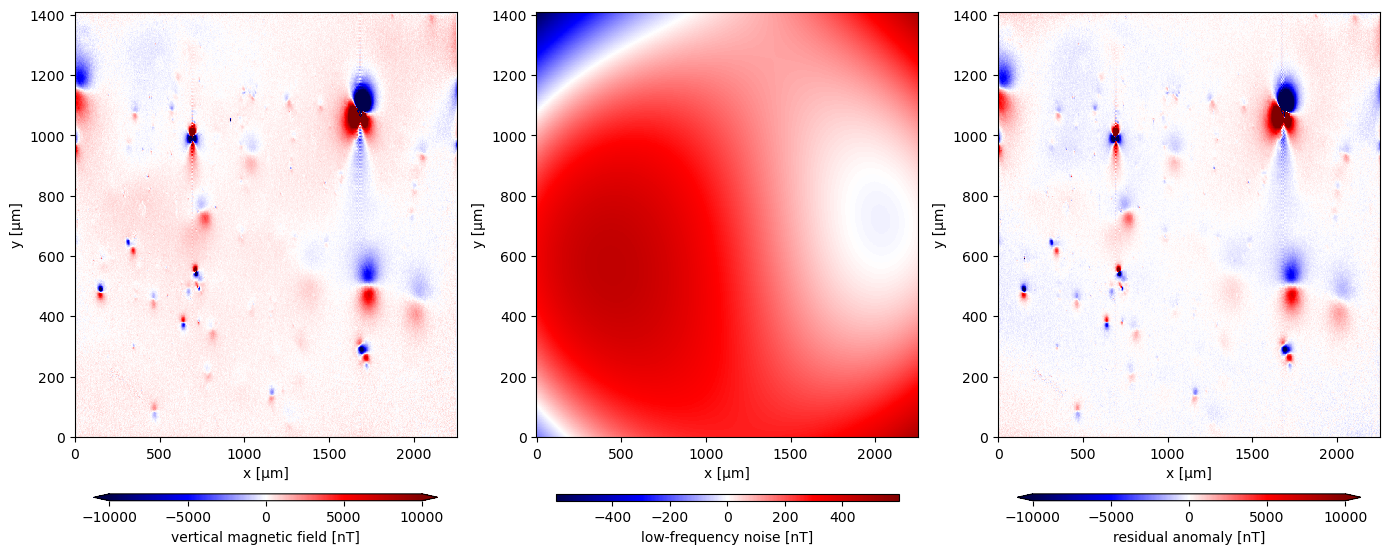

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "low_freq", "residual"], axes.ravel()):
    vmax, vmin = None, None
    if field != "low_freq":
        vmax=+10000
        vmin=-10000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
plt.tight_layout()

## 2. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [11]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.residual, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 179.4 272.2 330.3 374.5 ... -37.43 2.523 81.43

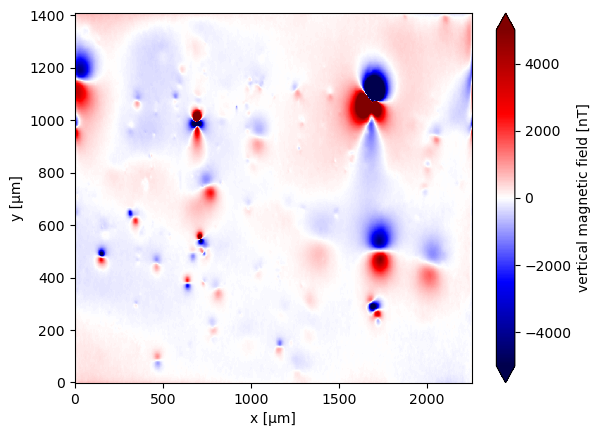

In [12]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

## 3. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [13]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 179.4 272.2 330.3 374.5 ... -37.43 2.523 81.43
    tga      (y, x) float64 41.31 39.91 30.8 31.58 ... 47.0 48.39 53.51 45.85
    x_deriv  (y, x) float64 39.52 32.11 21.76 16.75 ... 10.44 14.16 25.29 33.58
    y_deriv  (y, x) float64 -7.62 -9.232 -12.67 -16.62 ... -20.44 -16.89 -9.813
    z_deriv  (y, x) float64 -9.317 -21.84 -17.73 -20.98 ... 41.51 44.03 29.64

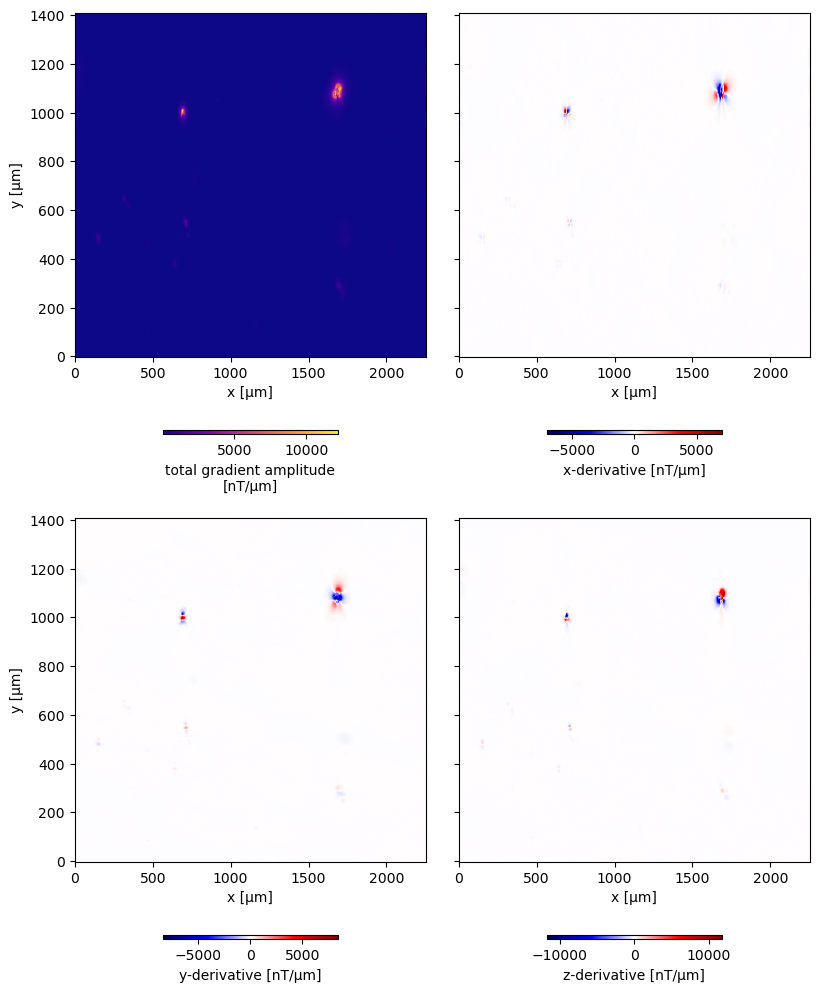

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
        vmax=None
        vmin=None
    else:
        vmax= None# 500
        vmin= None#-500
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 4. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [15]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

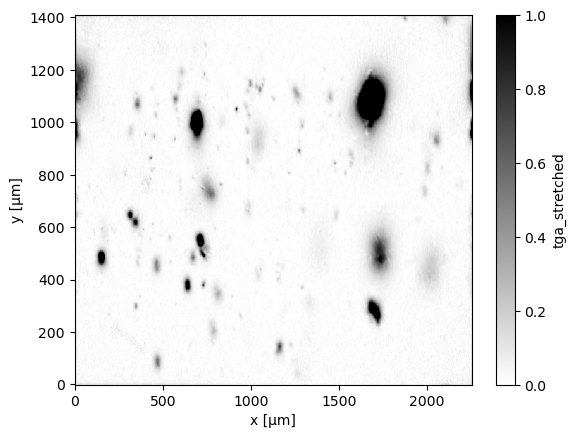

In [16]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 5. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [17]:
def detect_anomalies(
    data, size_range, size_increment=2, nsizes=10, threshold=0.5, overlap=0.5, exclude_border=0
):
    """
    Run the blob detection and produce bounding boxes in data coordinates
    """
    min_sigma, max_sigma = [0.5 * i for i in size_range]
    spacing = 2.35 #np.mean([np.abs(data.x[1] - data.x[0]), np.abs(data.y[1] - data.y[0])])
    print(spacing)
    iy, ix, sigma_pix = skimage.feature.blob_log(
        data,
        min_sigma=min_sigma / spacing,
        max_sigma=max_sigma / spacing,
        threshold=threshold,
        num_sigma=nsizes,
        overlap=overlap,
        exclude_border= int(exclude_border / spacing),
    ).T
    blob_coords = (data.x.values[ix.astype("int")], data.y.values[iy.astype("int")])
    blob_sizes = sigma_pix * np.sqrt(2) * spacing * size_increment
    windows = [
        [x - size, x + size, y - size, y + size]
        for size, x, y in zip(blob_sizes, *blob_coords)
    ]
    return windows

In [18]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 200],
    size_increment=1.5,
    threshold=0.025,
    overlap=0.0,
    exclude_border=20,
    nsizes=10
)
# windows


In [19]:
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  103


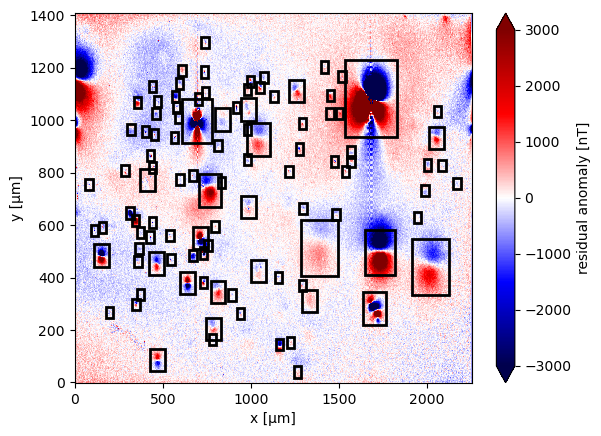

In [20]:
ax = plt.subplot(111)
data.residual.plot.pcolormesh(ax=ax, cmap="seismic", vmax=3000, vmin=-3000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)  
ax.set_aspect("auto")

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution

Run the Euler Deconvolution on each window to compare the true and estimated source positions.

In [21]:
positions = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    if position[2]<=0: # exclude positive z positions (failed Euler)
        print(position, base_level)
        positions.append(position)
#     plt.figure()
#     plt.contourf(anomaly.x, anomaly.y, anomaly.bz)
positions = np.transpose(positions)

[1685.47065574 1084.39731336  -20.18180764] 2.3327697587601945
[ 690.84106387 1000.32649541   -5.93441938] 106.54676237258646
[150.87337899 483.40054904  -9.92968967] -201.03750838208228
[1693.75376344  284.28386633  -14.59090807] 78.62316054841415
[712.34760352 547.56648534  -4.52842066] 136.49814399140578
[639.98093893 379.5179557   -8.65224258] -70.99254679972613
[317.21562862 644.03754548 -10.85245171] 31.86040104646399
[338.98312515 626.65351122 -16.47896581] -149.01253846463823
[1732.52551651  501.12299626  -59.53935886] -132.93826631249289
[ 7.34292608e+02  4.99834192e+02 -5.16849752e-01] -24.73947972145724
[1163.19831838  139.42141634  -12.37180502] -69.63068306107616
[730.48022797 381.59305532  -2.39150178] -34.34965524854726
[ 356.29298793 1073.0648417   -13.22818536] -215.9571168221665
[469.00488714  86.19349786 -14.09095404] 49.48758311384444
[ 574.87118558 1086.14570504   -9.72559477] -192.47507810046153
[671.27039524 488.35368199 -13.55501462] -47.648031908865455
[770.048

# Dipole moment inversion

With the source positions found through Euler Deconvolution, we can now estimate the dipole moment through a linear inversion.

In [58]:
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []

# # using data up
# for window, position in zip(windows, positions.T):
#     anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
#     moment, covariance, r2, SNR = mg.dipole_moment_inversion(
#         anomaly.bz, position,
#     )
#     estimated_dipole_moments.append(moment)
#     estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
#     calculated_r2.append(r2)
#     calculated_SNR.append(SNR)
#     print("R²: %s and SNR: %s"%(r2,SNR))
    

# using residual data
for window, position in zip(windows, positions.T):
    anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.residual, position,
    )
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    print("R²: %s and SNR: %s"%(r2,SNR))

R²: 0.6880561461624619 and SNR: 5.062216333540031
R²: 0.7982447020642622 and SNR: 6.972796774883784
R²: 0.9793548133809716 and SNR: 17.887260544215813
R²: 0.6980951308877141 and SNR: 5.225792798537673
R²: 0.9572802795825409 and SNR: 13.7595579068945
R²: 0.9803763125711357 and SNR: 17.8452987831873
R²: 0.9156060733429119 and SNR: 10.754598419604864
R²: 0.900791538431156 and SNR: 10.118599880151875
R²: 0.991833435780496 and SNR: 22.207897647410313
R²: 0.19781278023679127 and SNR: 1.0637743788987302
R²: 0.9686234188692726 and SNR: 15.101971573241881
R²: 0.0016440413323074443 and SNR: 0.007145878513362237
R²: 0.09650030612961003 and SNR: 0.4407199030174977
R²: 0.41772122274440526 and SNR: 2.3486913919587185
R²: 0.20421461998934265 and SNR: 0.9920411985812876
R²: 0.2492685525832924 and SNR: 1.245158475431272
R²: 0.3029402868053951 and SNR: 1.5673953809973526
R²: 0.3110892522970631 and SNR: 1.61961435648593
R²: 0.15250409685724997 and SNR: 0.7268419720518688
R²: 0.0833788396218339 and SNR: 0

In [59]:
for estimated, sigmas, r2, SNR in zip(estimated_dipole_moments, estimated_stds, calculated_r2, calculated_SNR):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    print(f"Inclination: {einc} ± {sigma_inc:.3f}")
    print(f"Declination: {edec} ± {sigma_dec:.3f}")
    print(f"Amplitude  : {eamp:e} ± {sigma_amp:.1e}")
    print(f"R²   : {r2:.5f} ")
    print(f"SNR  : {SNR:.5f} ")
    print()


Inclination: 16.954965075486786 ± 0.233
Declination: -151.12178400096948 ± 0.331
Amplitude  : 2.914506e-11 ± 1.6e-13
R²   : 0.68806 
SNR  : 5.06222 

Inclination: -22.14919174802391 ± 0.318
Declination: 5.639802026860914 ± 0.455
Amplitude  : 1.931417e-12 ± 1.4e-14
R²   : 0.79824 
SNR  : 6.97280 

Inclination: 21.298300275895404 ± 0.178
Declination: -173.14335151679776 ± 0.254
Amplitude  : 4.249805e-13 ± 1.7e-15
R²   : 0.97935 
SNR  : 17.88726 

Inclination: 53.27941611682928 ± 0.793
Declination: -179.7594458913316 ± 1.464
Amplitude  : 7.098156e-13 ± 8.9e-15
R²   : 0.69810 
SNR  : 5.22579 

Inclination: -1.8212539722703467 ± 0.232
Declination: -16.43308263097825 ± 0.328
Amplitude  : 2.983489e-13 ± 1.7e-15
R²   : 0.95728 
SNR  : 13.75956 

Inclination: 0.6516947921364842 ± 0.155
Declination: -1.7099744076740866 ± 0.219
Amplitude  : 1.955087e-13 ± 7.5e-16
R²   : 0.98038 
SNR  : 17.84530 

Inclination: 70.41367650025721 ± 1.045
Declination: 110.66476526079872 ± 3.198
Amplitude  : 1.498764e

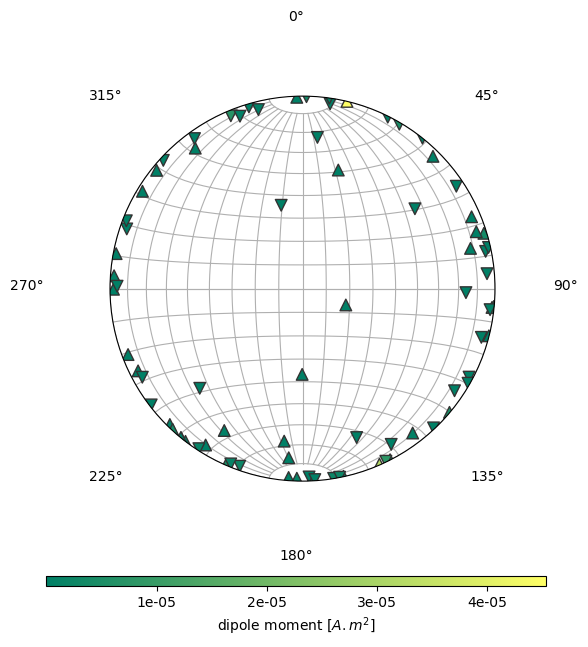

In [60]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5))
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
scatter_args = dict(
    vmin=np.min(estimated[2]),
    vmax=np.max(estimated[2]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="v",
    **scatter_args,
)


fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

### OBS: Intensidades muito altas

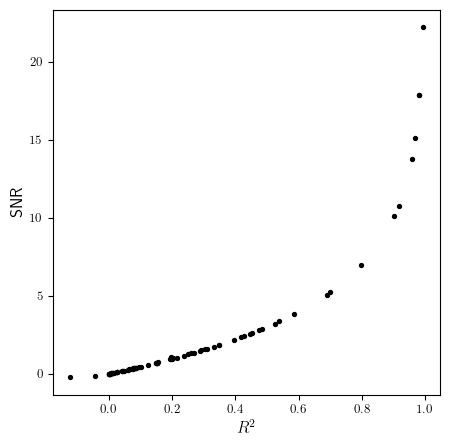

In [62]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):
    size=8
    fig, ax = plt.subplots(1,1, figsize=(5,5))    


    ax.scatter(calculated_r2, calculated_SNR, color='k', s=size)
    ax.set_xlabel('$R^2$', fontsize=12)
    ax.set_ylabel('SNR', fontsize=12)


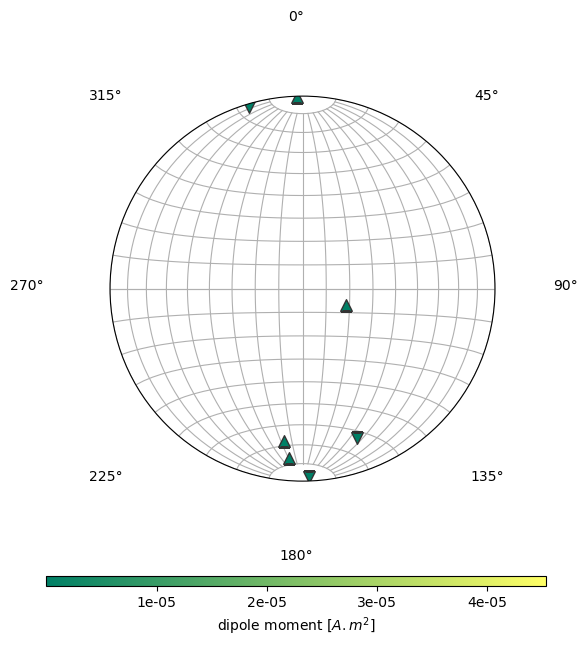

7


In [66]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5))
ax.grid()

estimated = mg.vector_to_angles(estimated_dipole_moments)

scatter_args = dict(
    vmin=np.min(estimated[2]),
    vmax=np.max(estimated[2]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)

count = 0
for i in range(len(calculated_r2)):
    if calculated_r2[i] >= 0.85:
#     if calculated_SNR[i] >= 4:
        count += 1
        estimated = mg.vector_to_angles(estimated_dipole_moments[i])
        pos_inc = estimated[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
            c=estimated[2][pos_inc],
            marker="^",
            **scatter_args,
        )
        tmp = ax.scatter(
            *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
            c=estimated[2][~pos_inc],
            marker="v",
            **scatter_args,
        )

fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

print(count)

# Show Z estimate

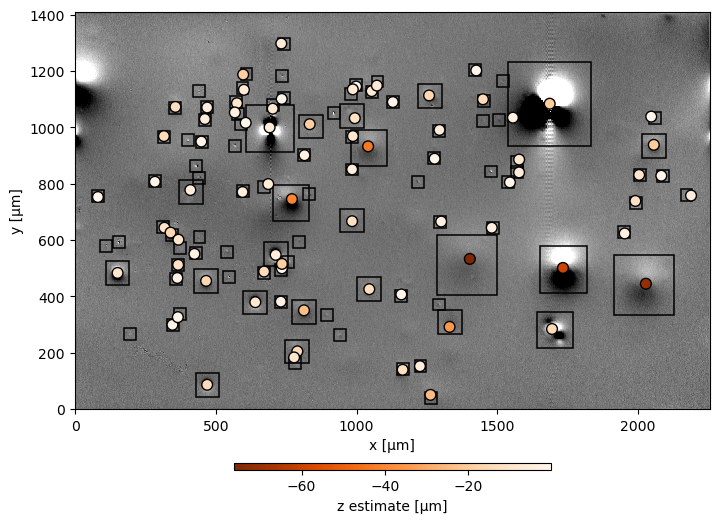

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False, levels=100)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="Oranges_r", s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

### Show each window data vs model

R²: 0.8875127196787952 and SNR: 9.503086096070021


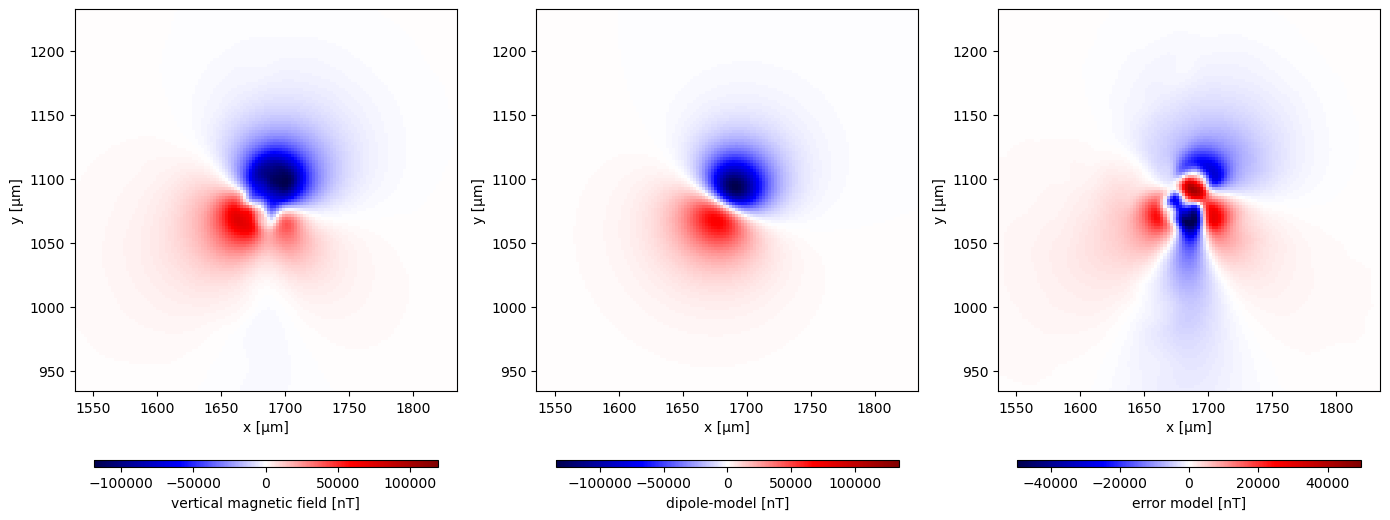

R²: 0.9141114202786691 and SNR: 10.846212383593521


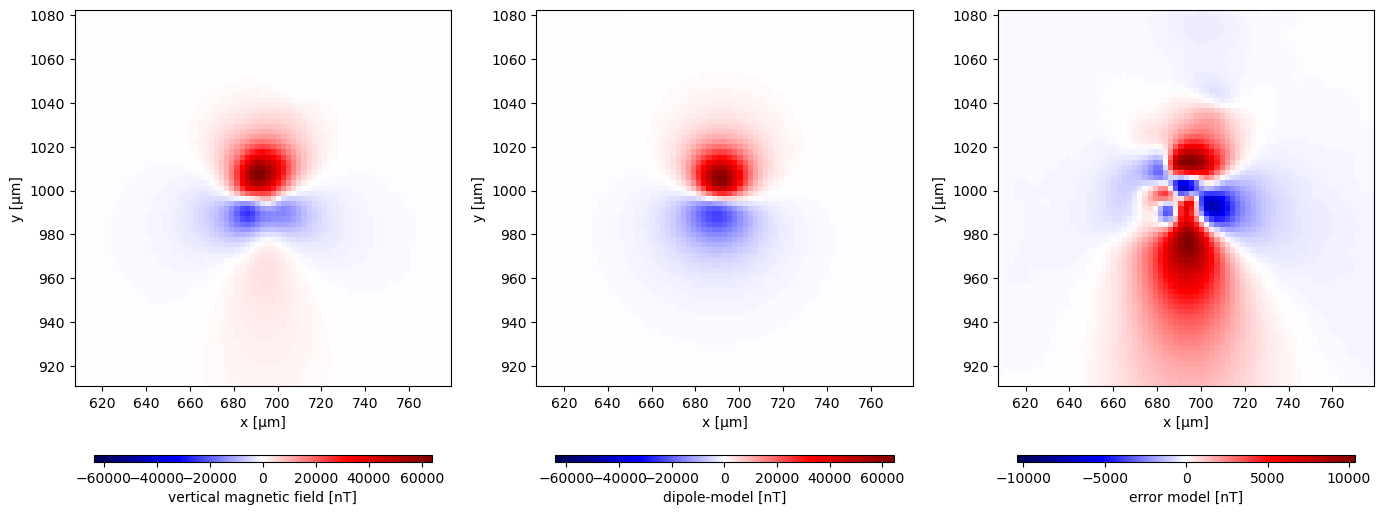

R²: 0.9803066319624194 and SNR: 21.552308841313405


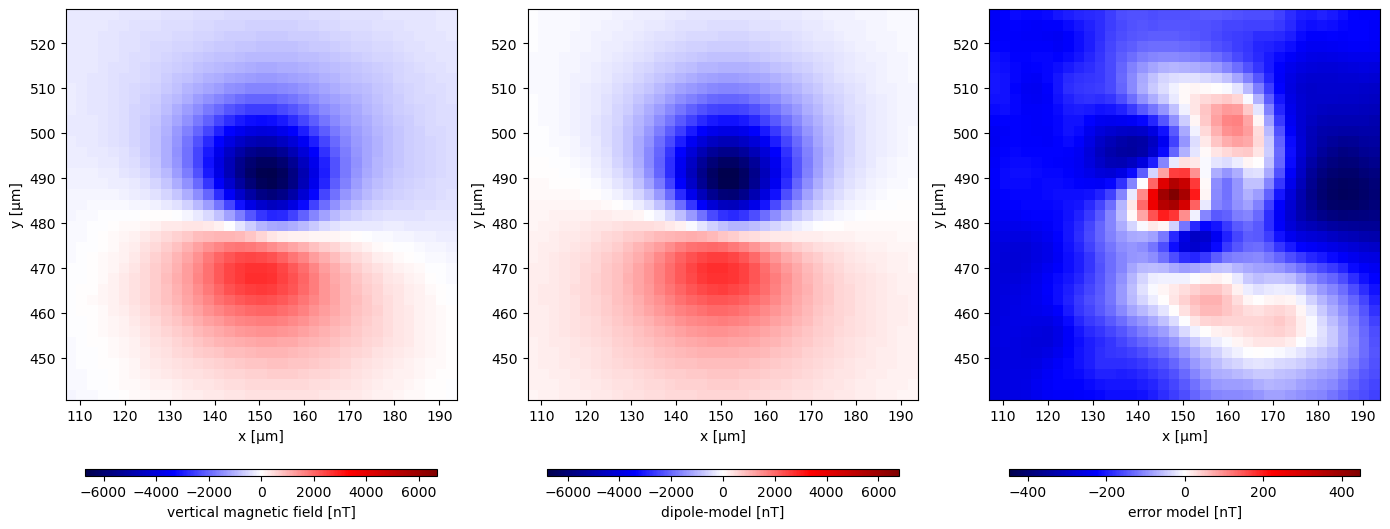

R²: 0.7398908769335504 and SNR: 5.940315309733295


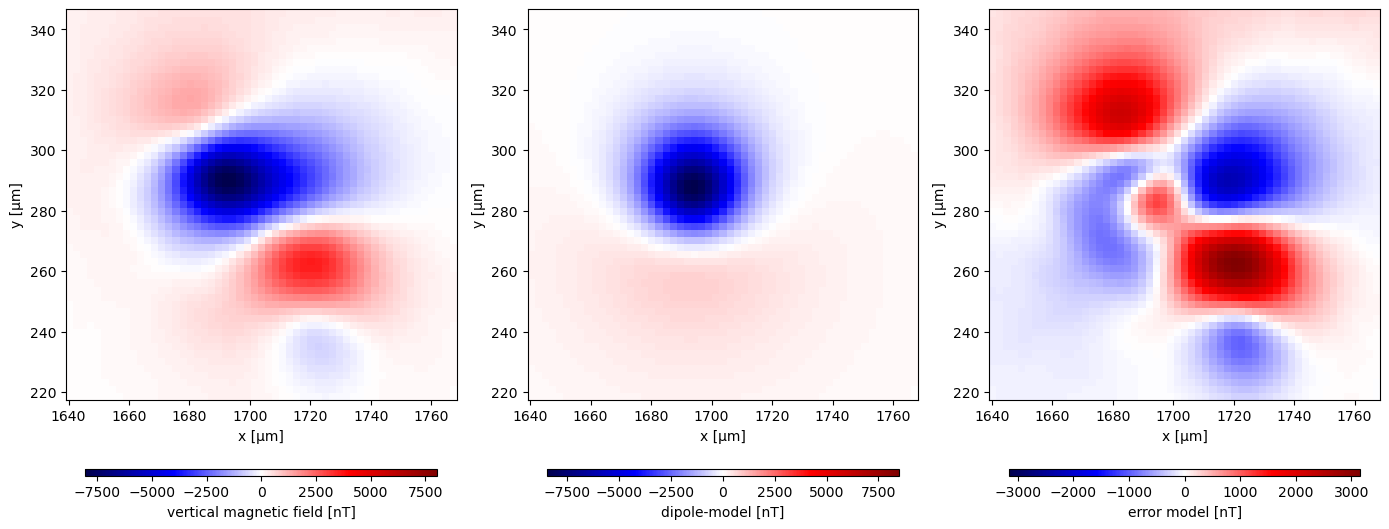

R²: 0.9557204521146315 and SNR: 13.806681926585807


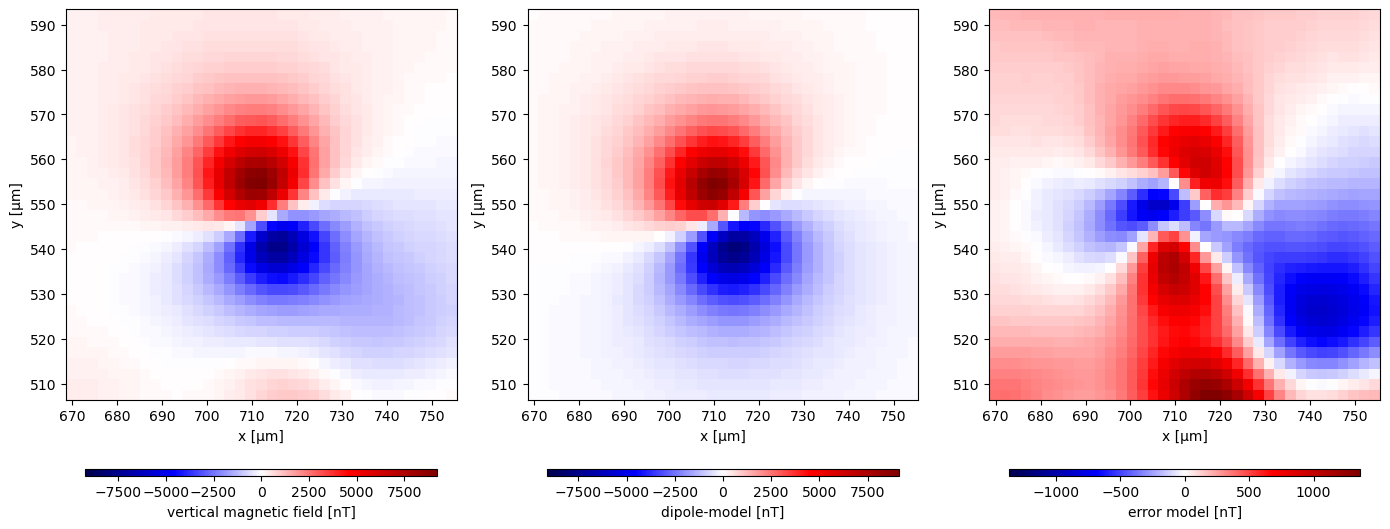

R²: 0.9868568978968352 and SNR: 23.742145390434935


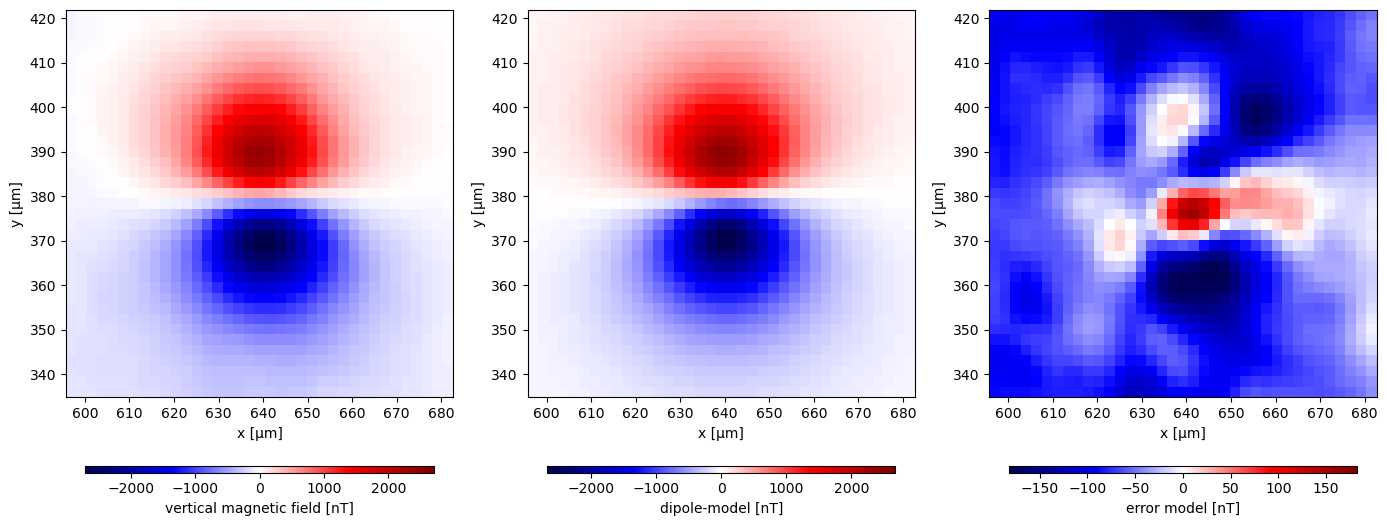

R²: 0.9605122397197484 and SNR: 14.03636398130762


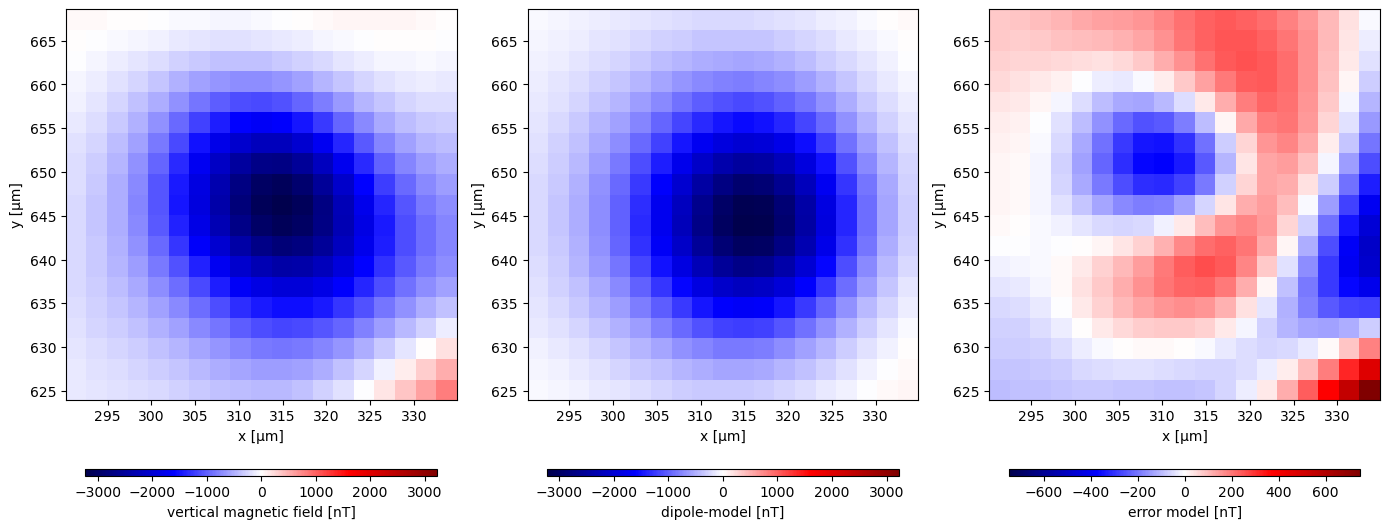

R²: 0.946855931210281 and SNR: 13.085727546852418


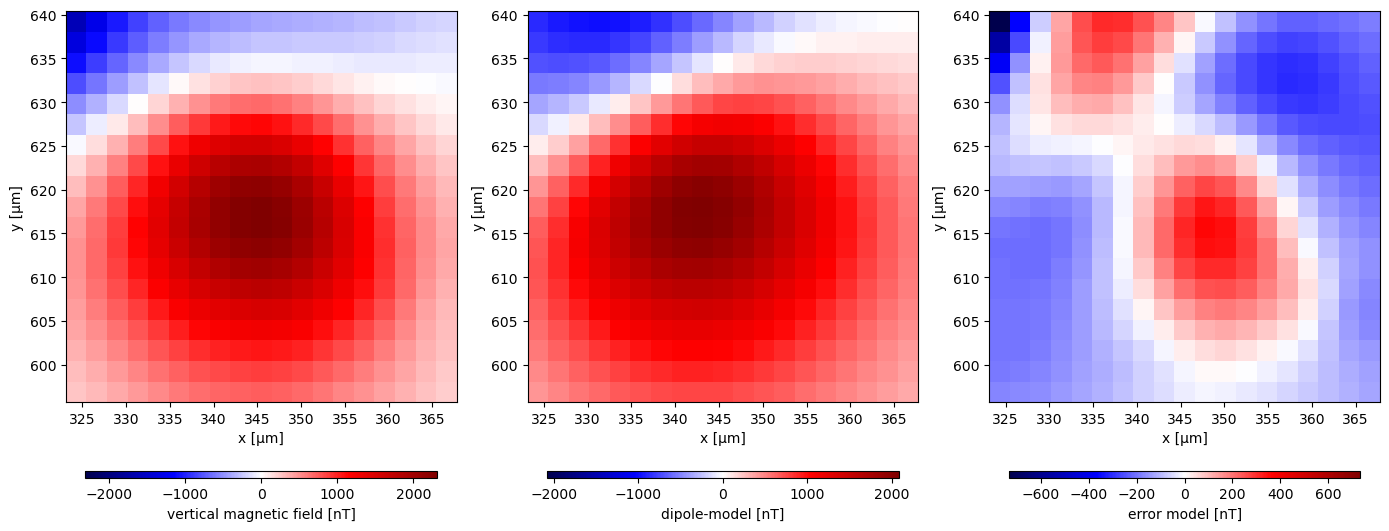

R²: 0.9953925033107726 and SNR: 26.308145868430156


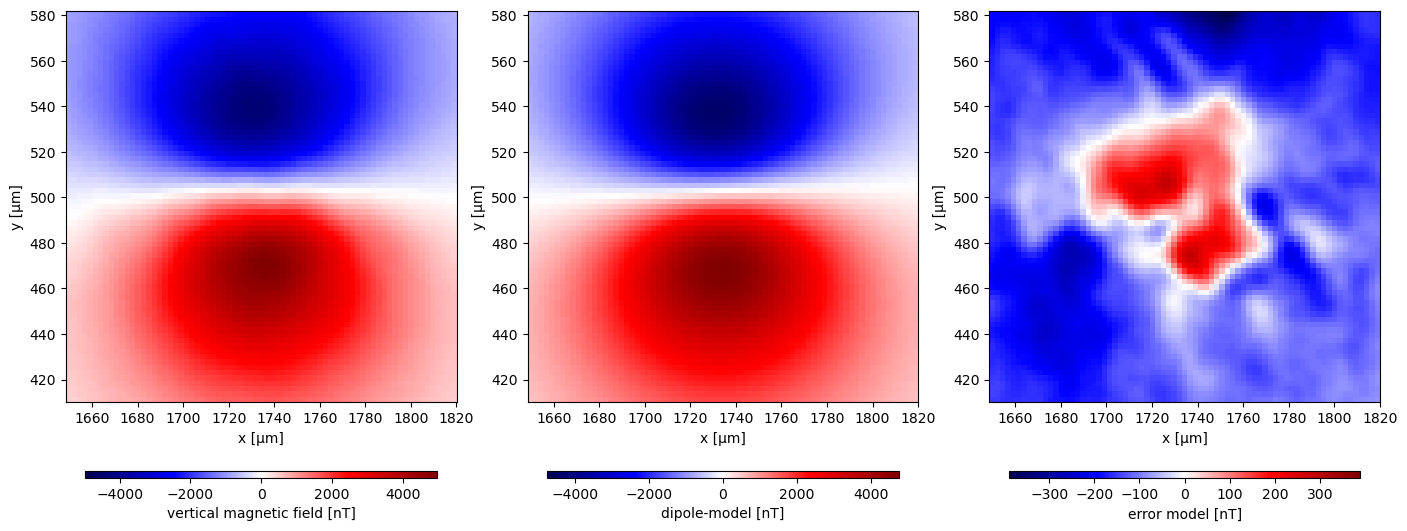

R²: 0.418216432393268 and SNR: 2.5059120374489305


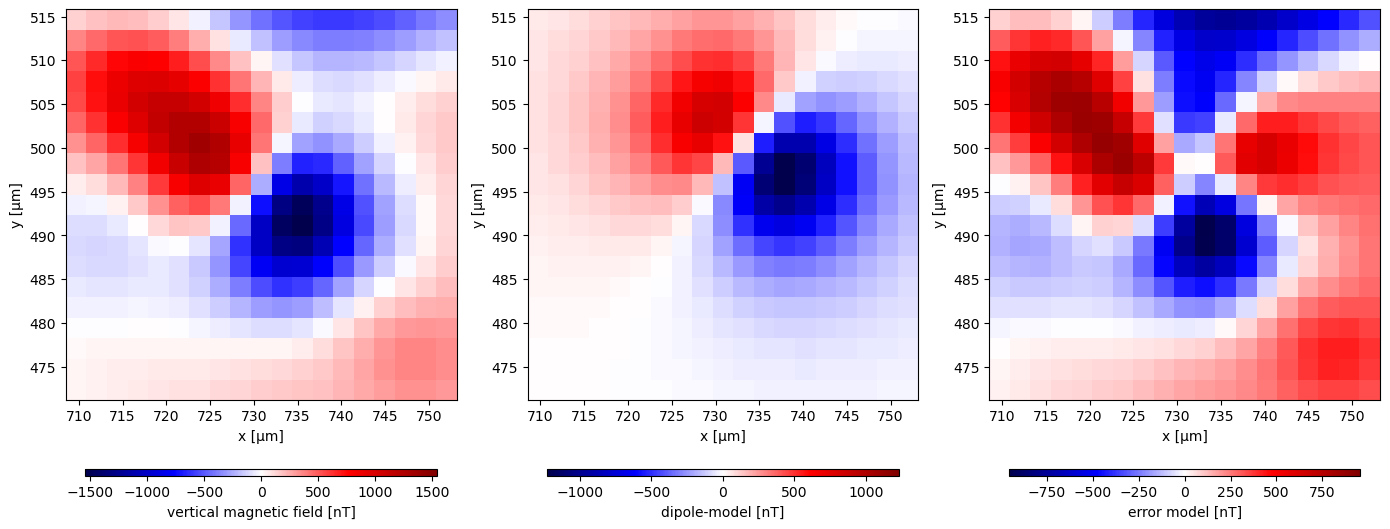

R²: 0.9911030211036653 and SNR: 21.364249573745838


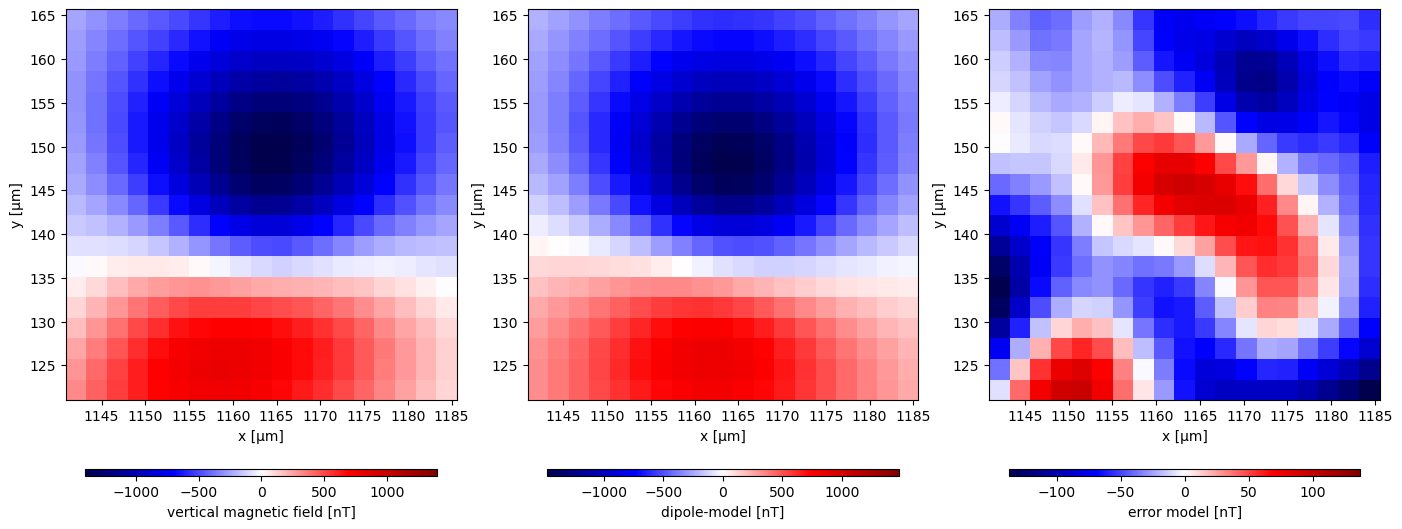

R²: 0.0479447371332129 and SNR: 0.21337903488277435


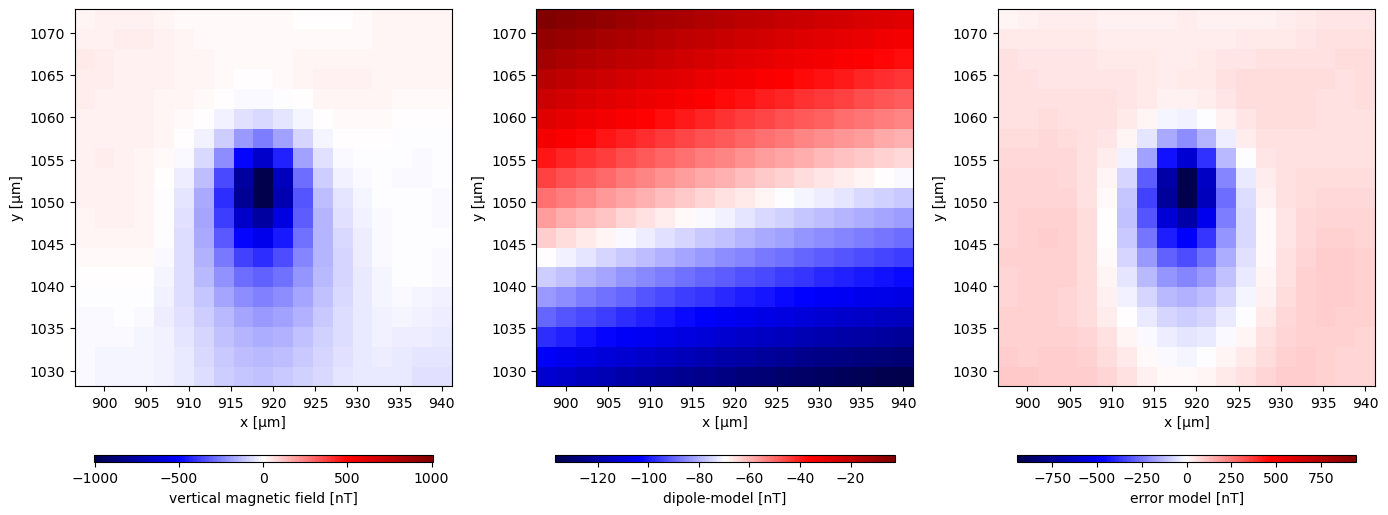

R²: 0.33055754907892054 and SNR: 1.7428675163370273


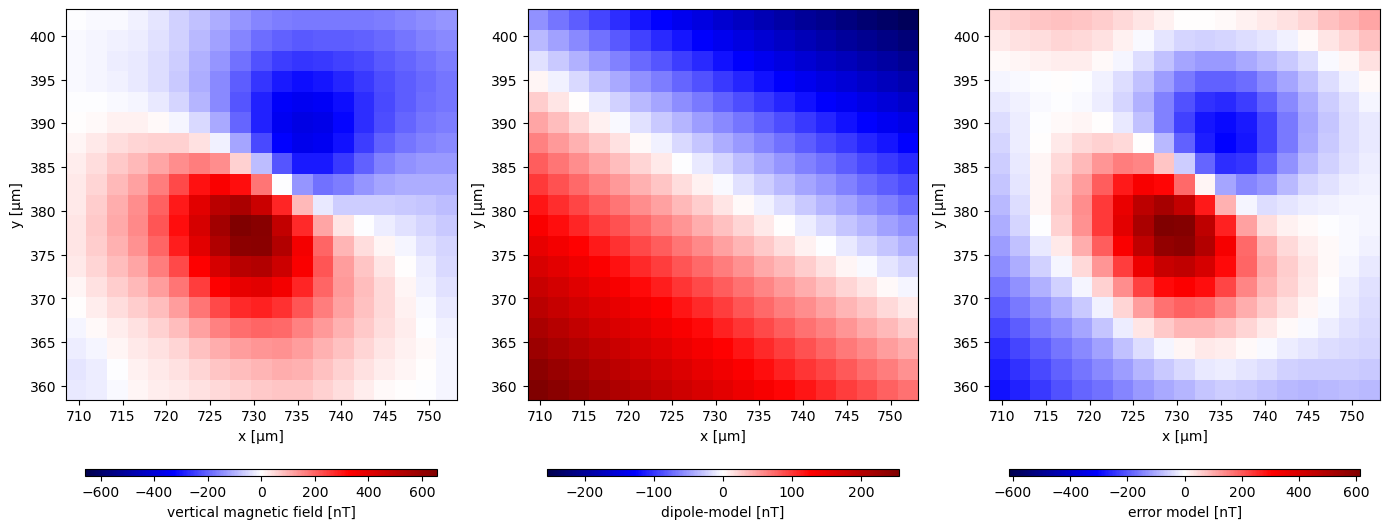

R²: 0.5646142319416145 and SNR: 3.611258872630038


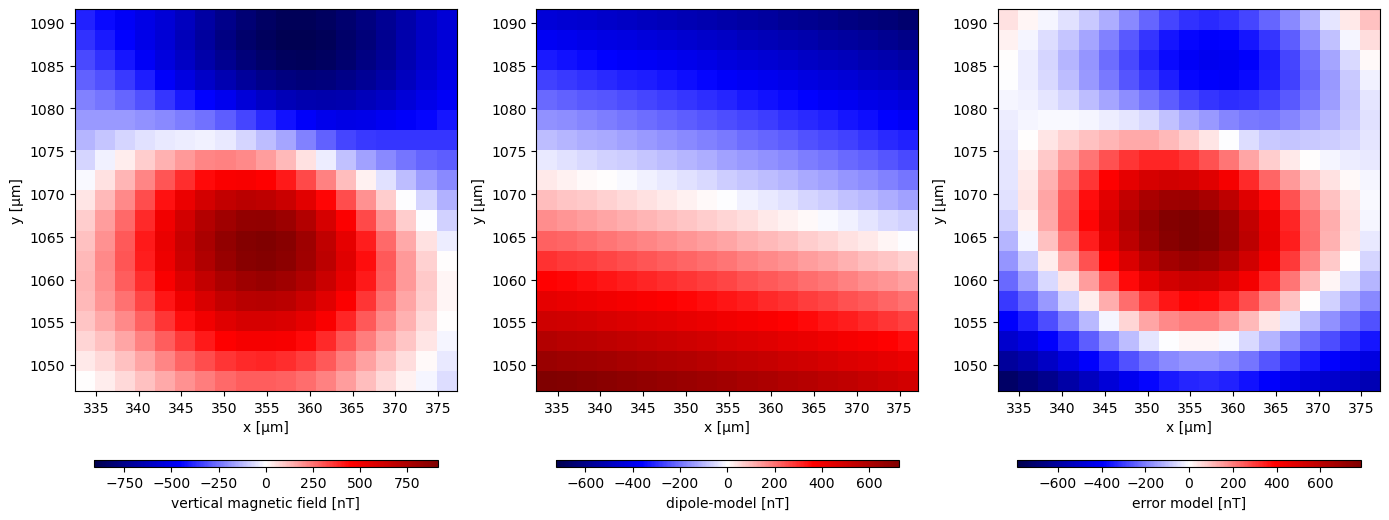

R²: 0.3283365315444504 and SNR: 1.7284839039243816


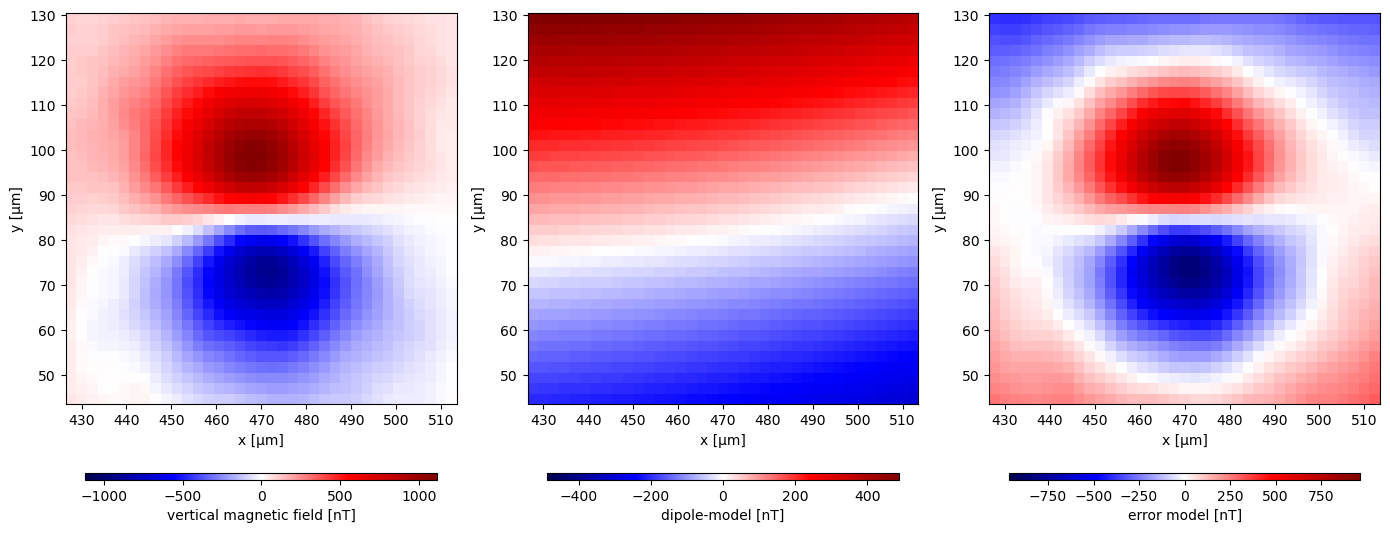

R²: 0.3778265868519737 and SNR: 2.0608911162404127


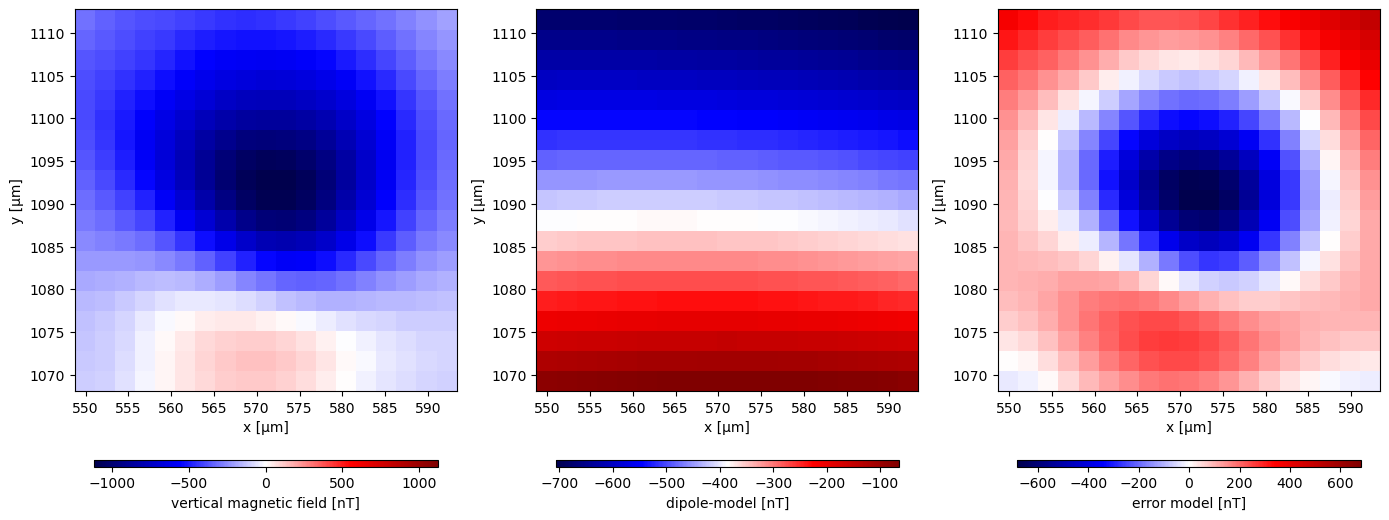

R²: 0.42421122575867687 and SNR: 2.3974730460424714


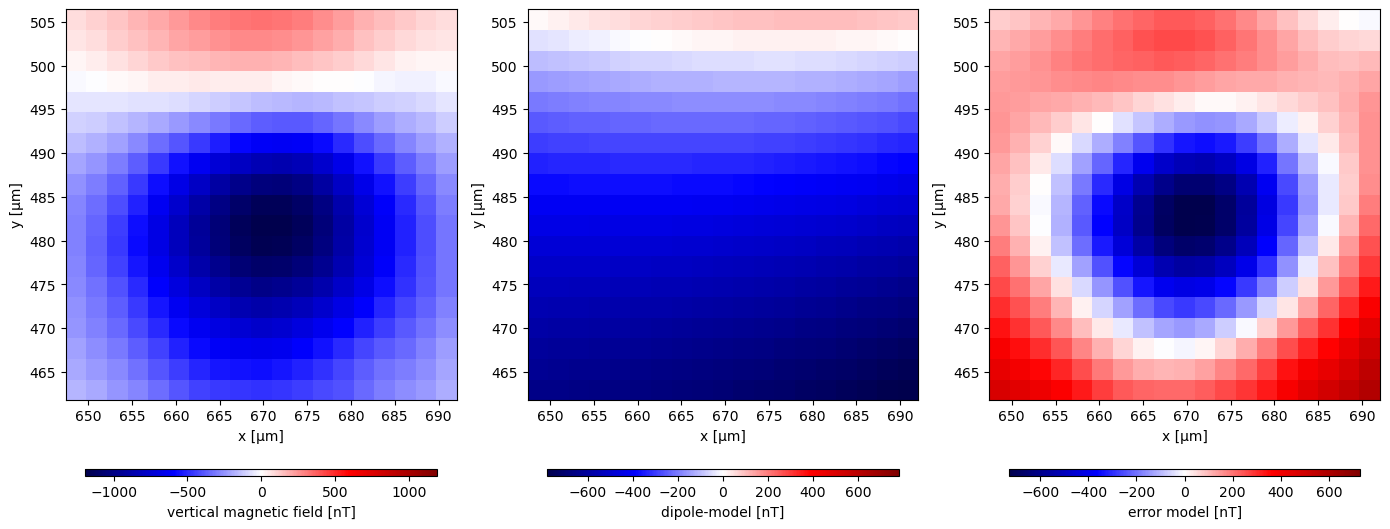

R²: 0.3742640968258185 and SNR: 2.037588128660851


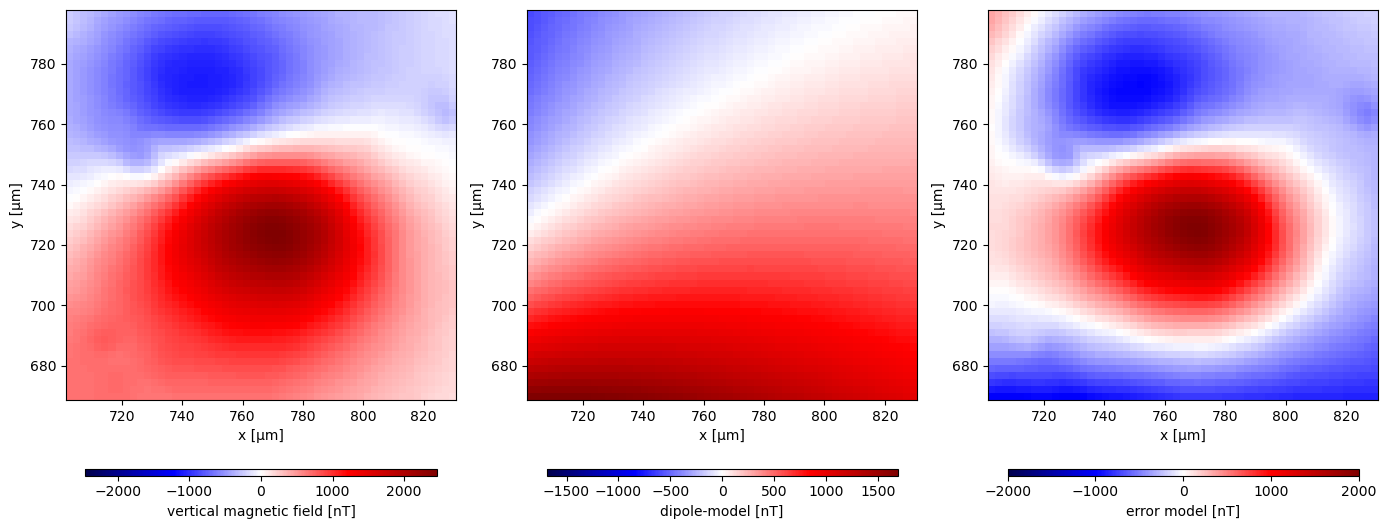

R²: 0.2332127276402034 and SNR: 1.1668760009850503


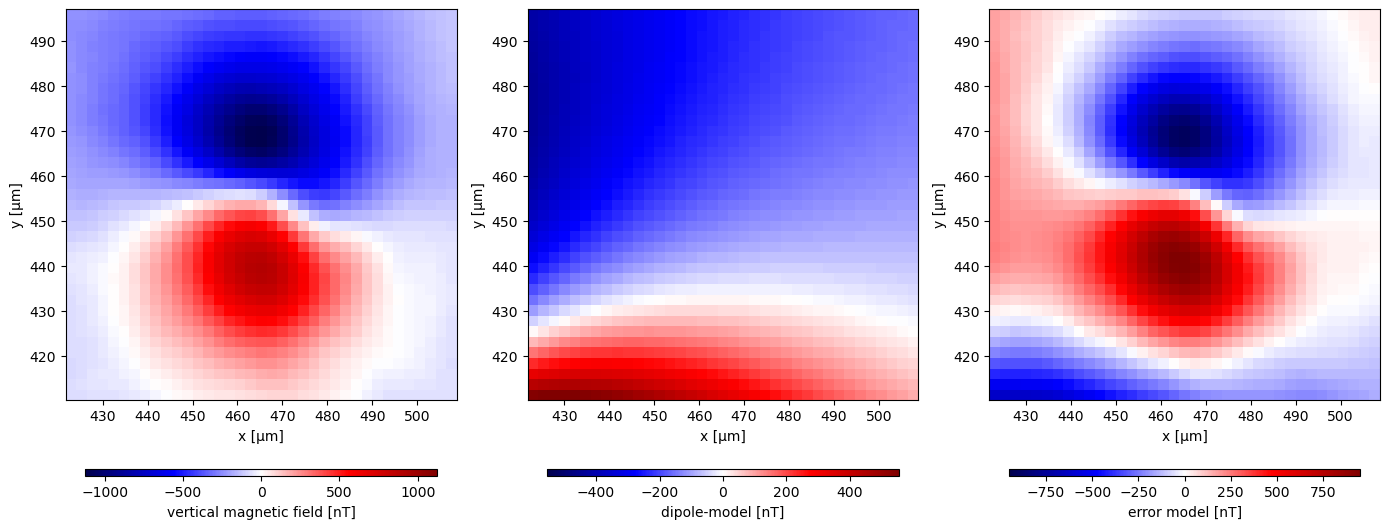

R²: 0.3524146577749354 and SNR: 1.8870298986940428


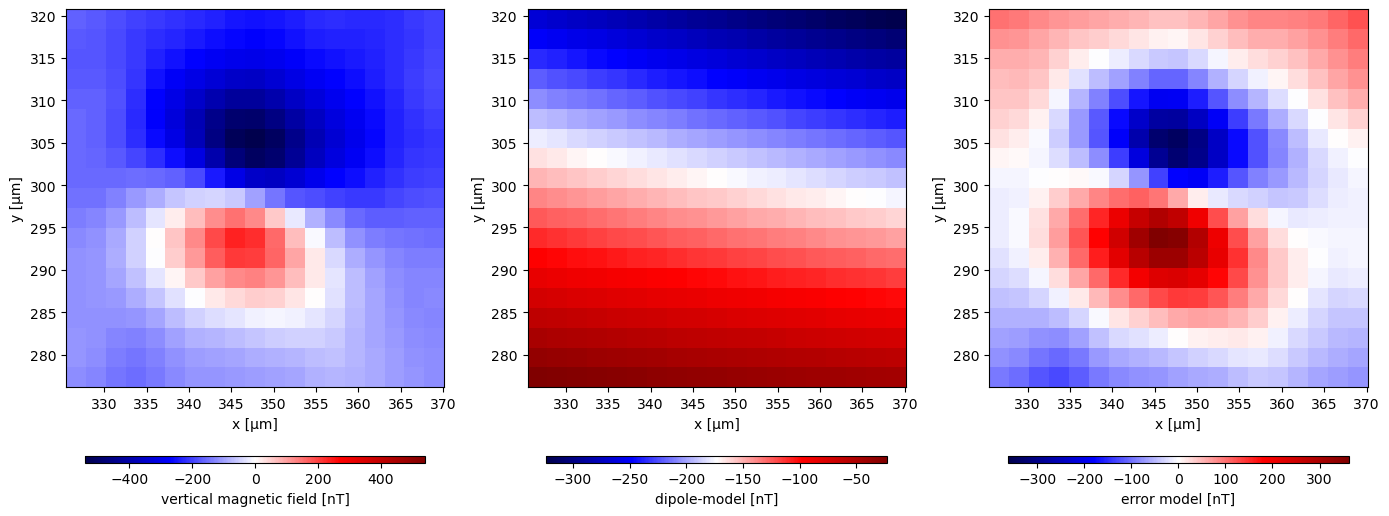

R²: 0.6457749271292184 and SNR: 4.507207019257804


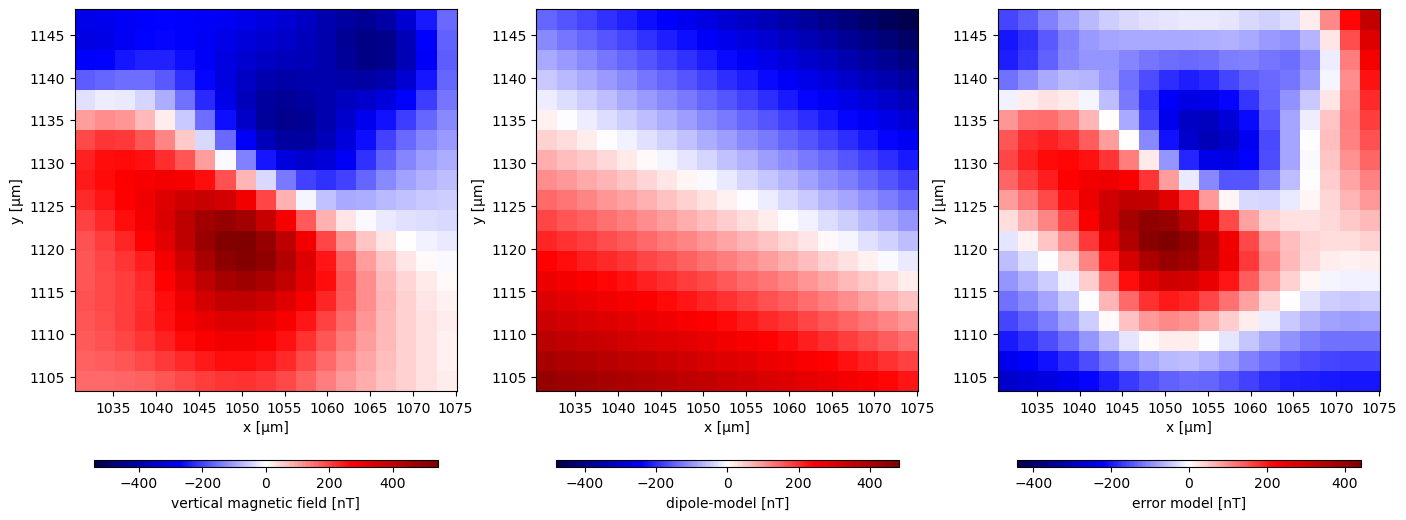

R²: 0.4814544573078262 and SNR: 2.8521346433713


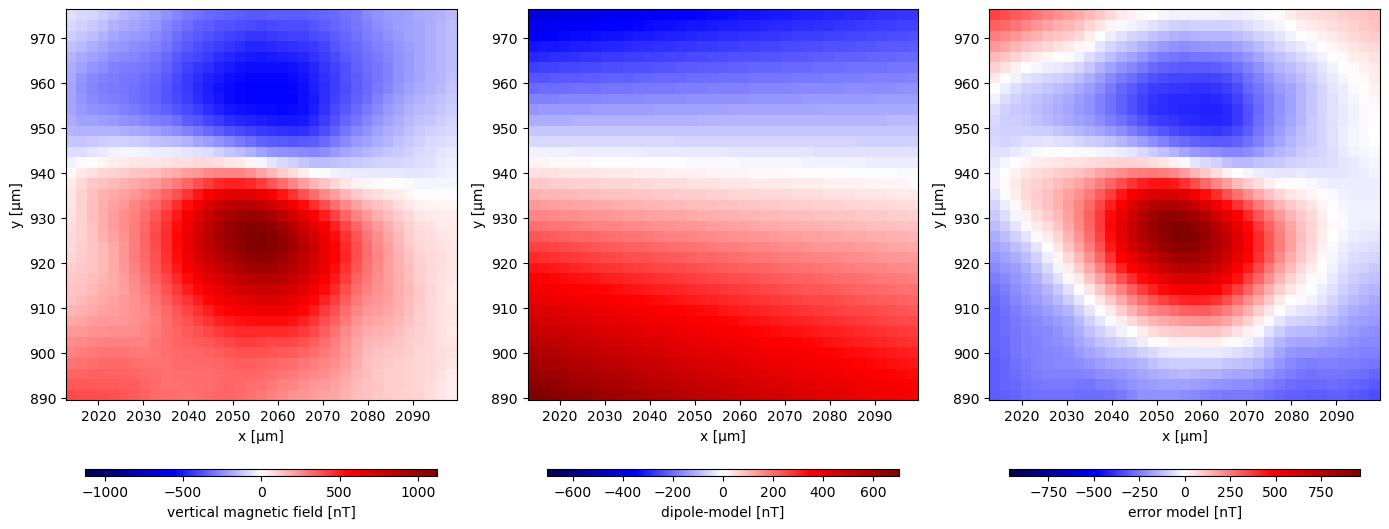

R²: 0.17497168993302414 and SNR: 0.8353270147560352


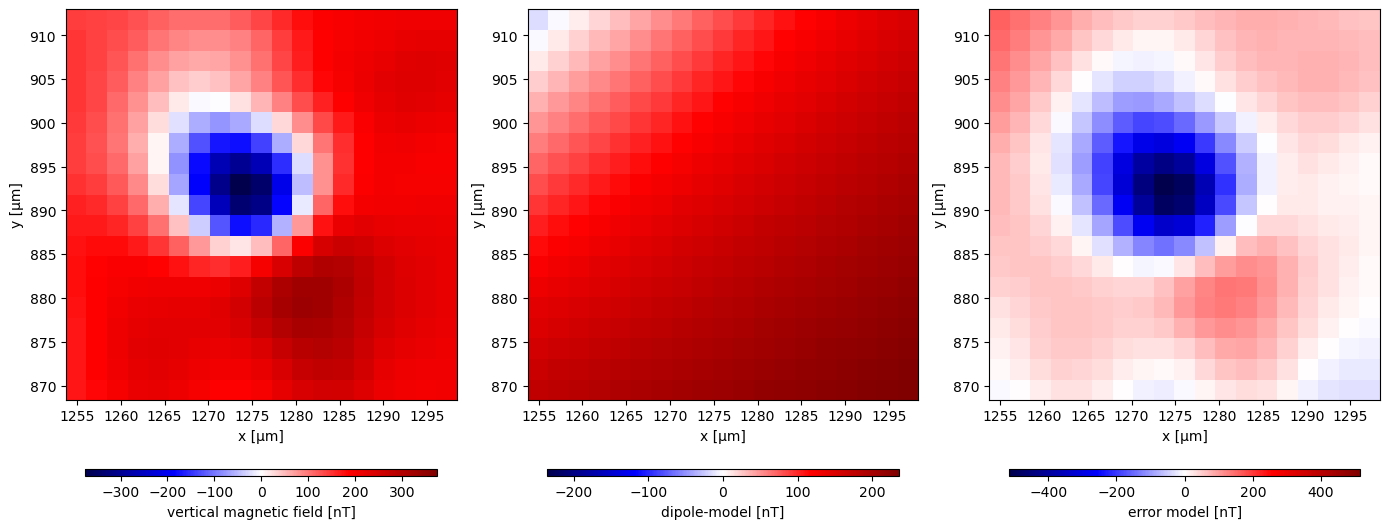

R²: 0.11686603887654246 and SNR: 0.5397384352610154


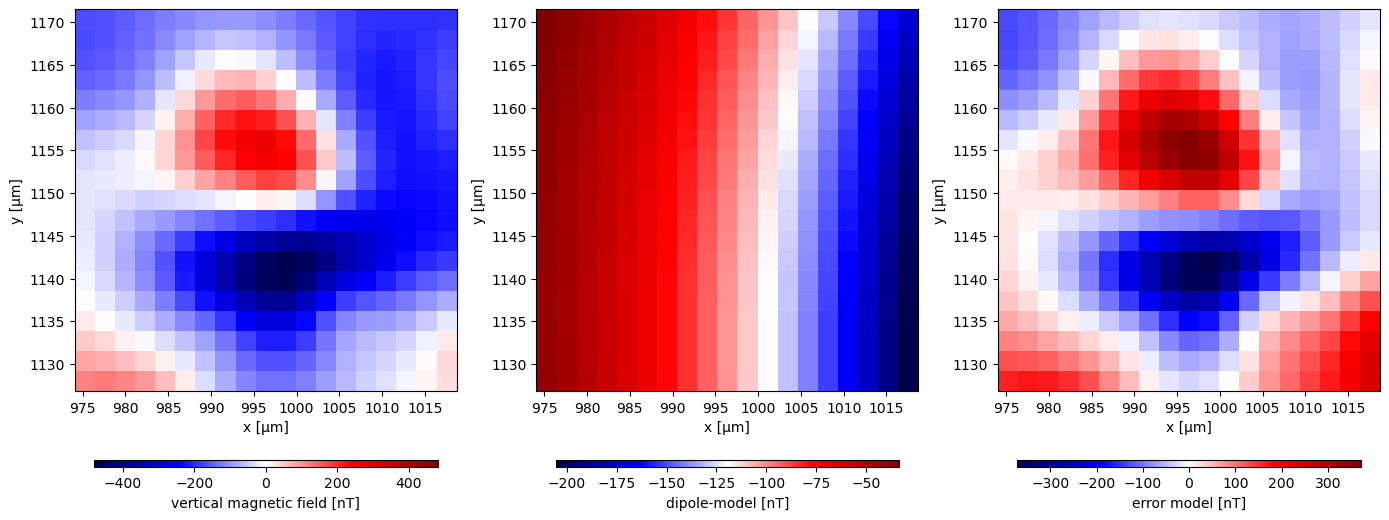

R²: 0.4363609234140149 and SNR: 2.4899947833561913


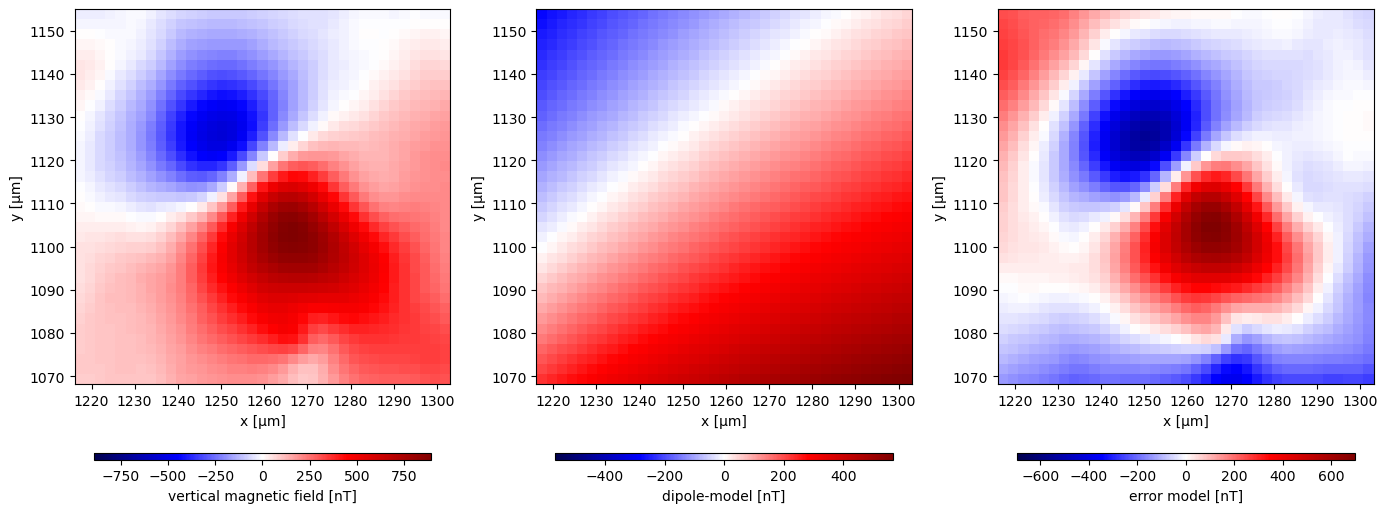

R²: 0.4492245382296237 and SNR: 2.590254206377194


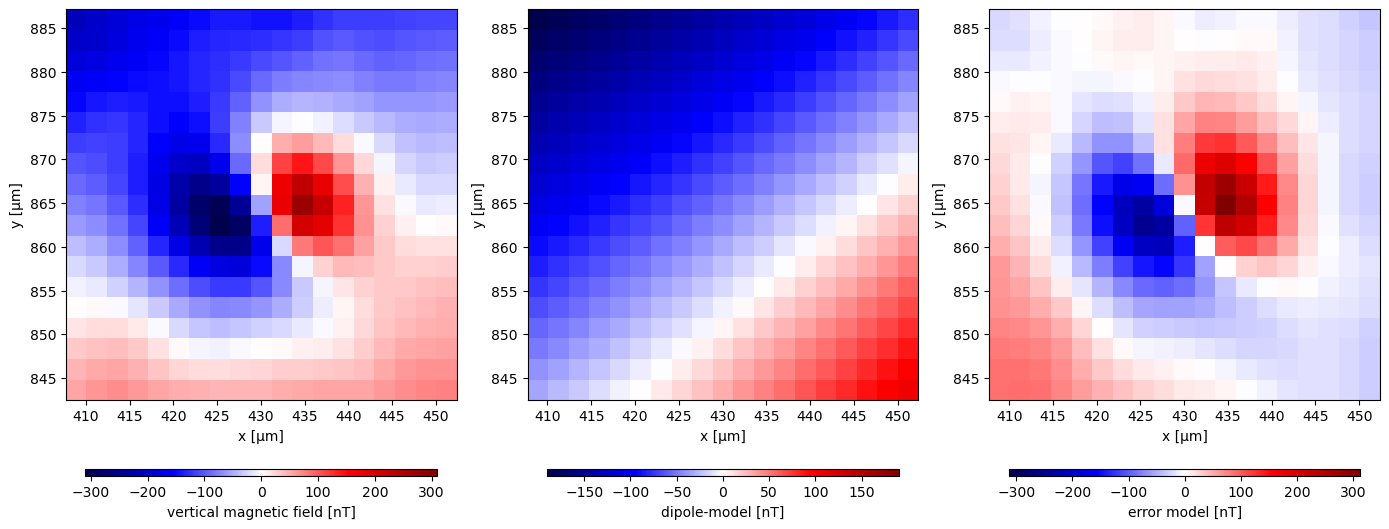

R²: 0.22202853458830807 and SNR: 1.1233035119918193


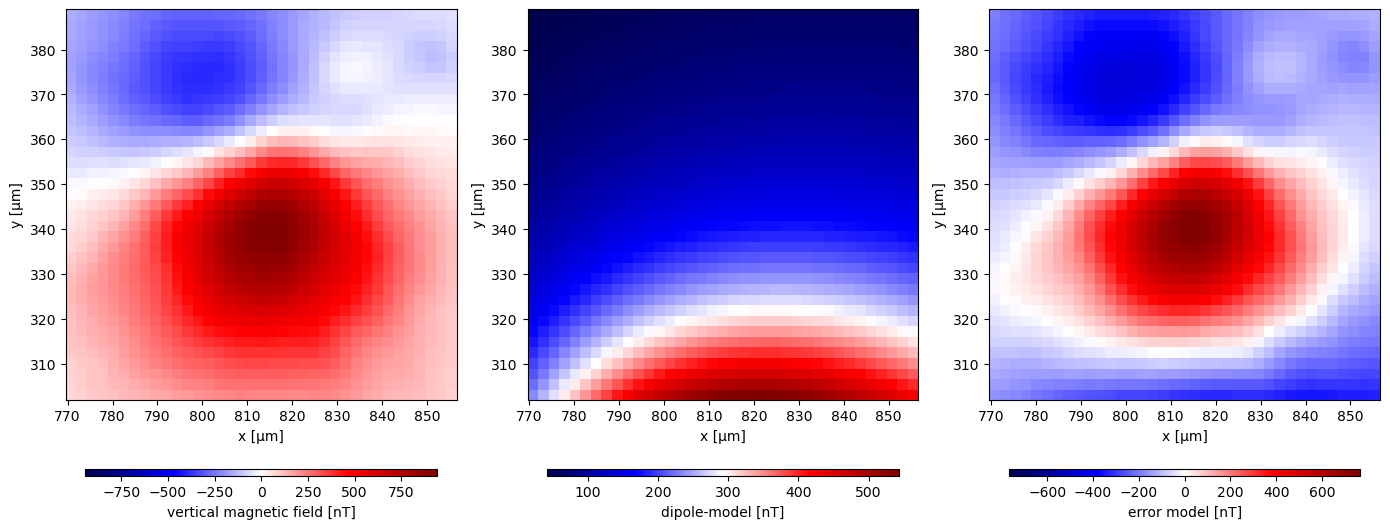

R²: 0.7113067628070633 and SNR: 5.395637181188217


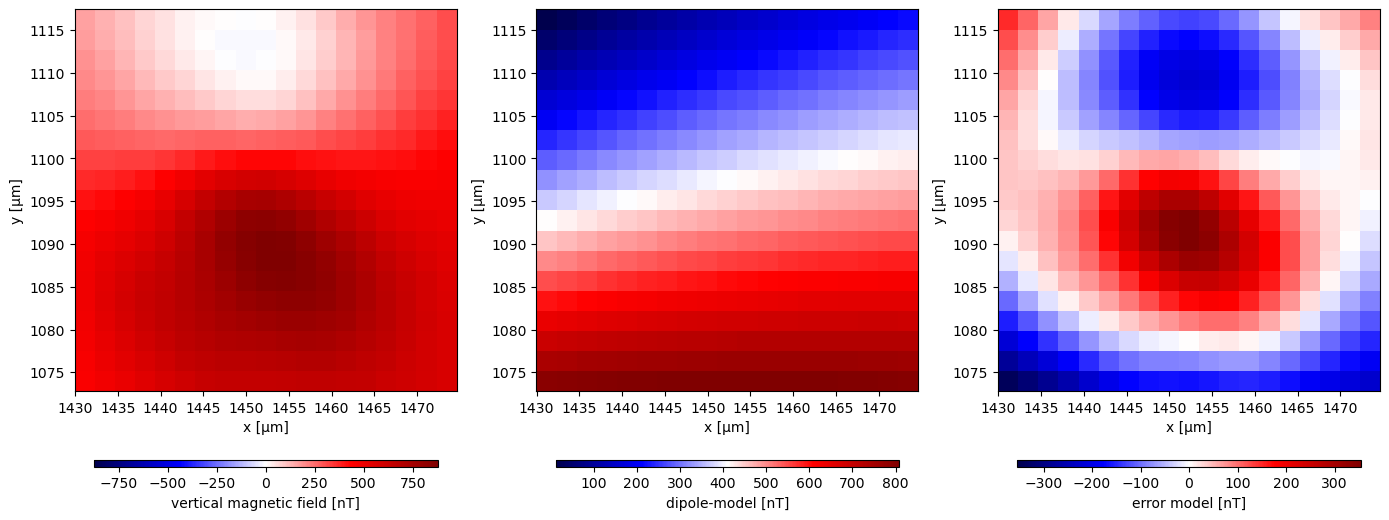

R²: 0.21676837671226534 and SNR: 1.0610984692714003


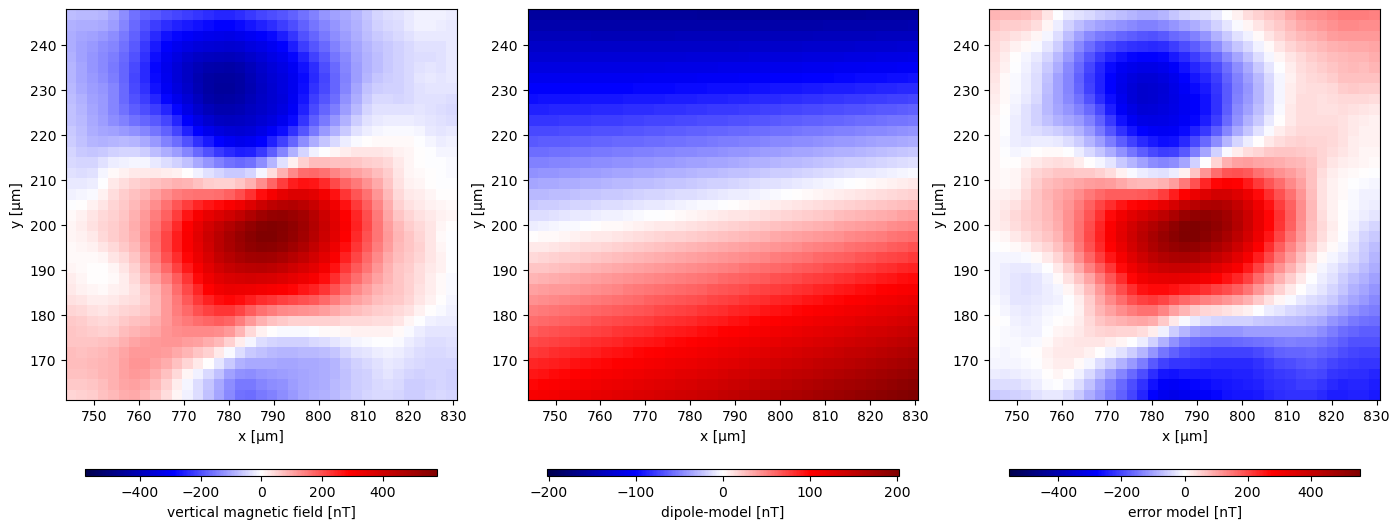

R²: 0.5080425023400937 and SNR: 3.080733773336237


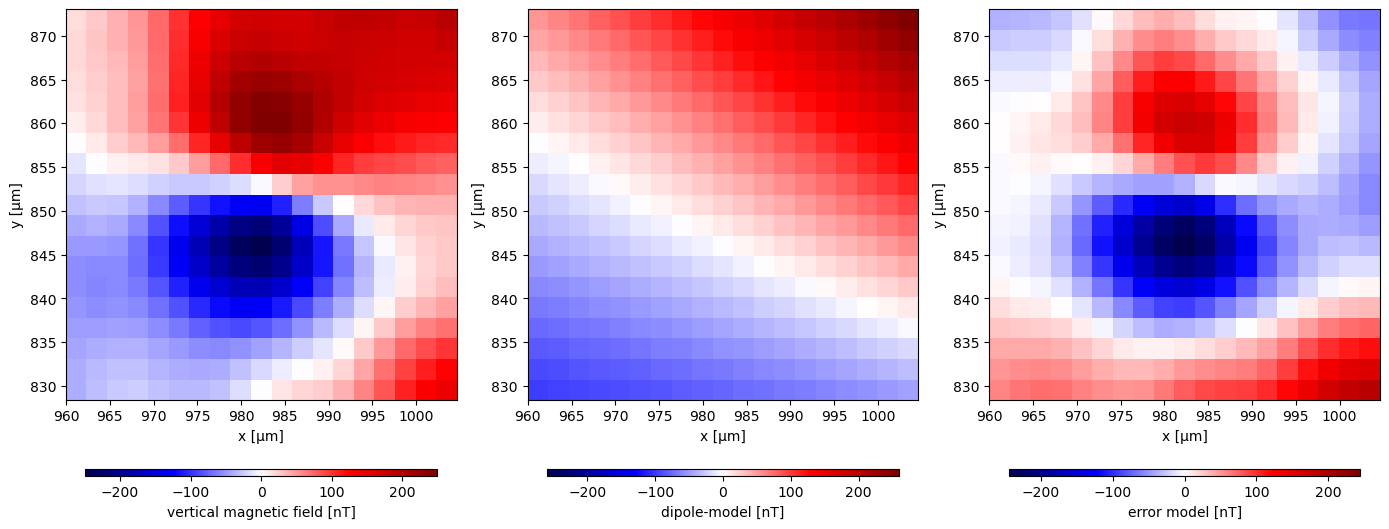

R²: 0.5444286809216508 and SNR: 3.4144853949500398


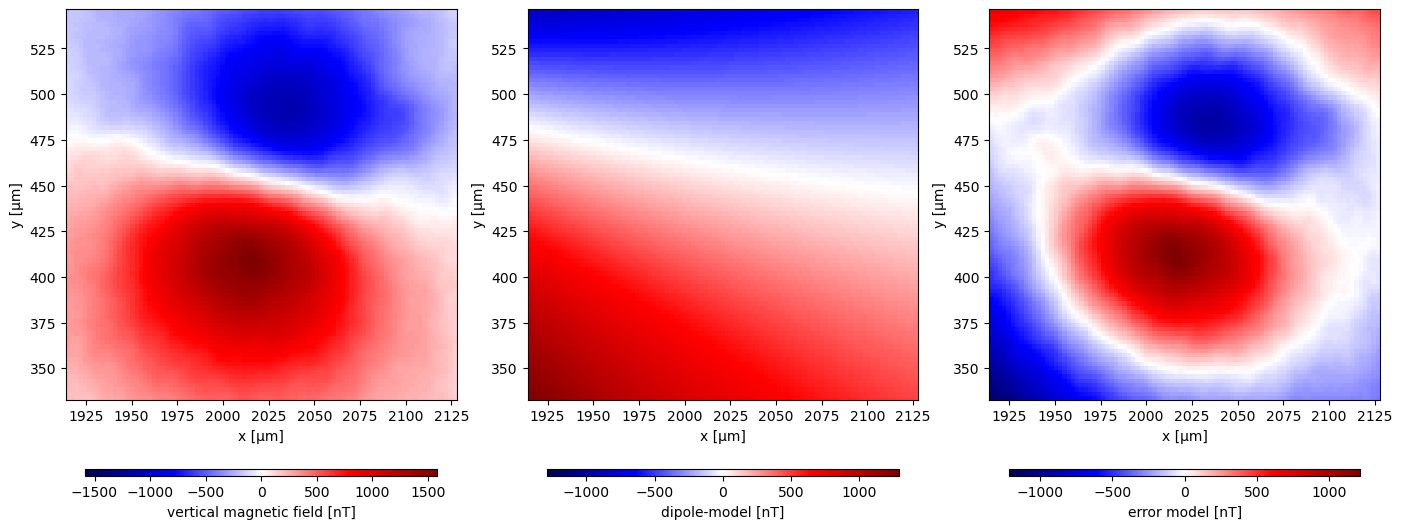

R²: 0.42851918093480823 and SNR: 2.429983418069565


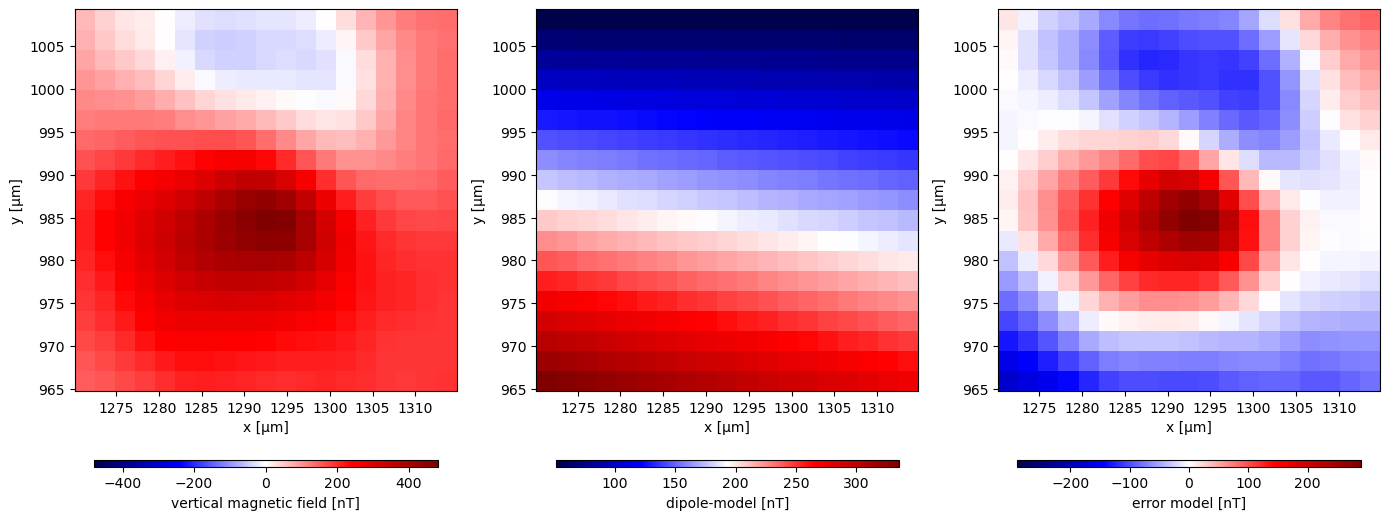

R²: 0.32264157935551385 and SNR: 1.6918165397042741


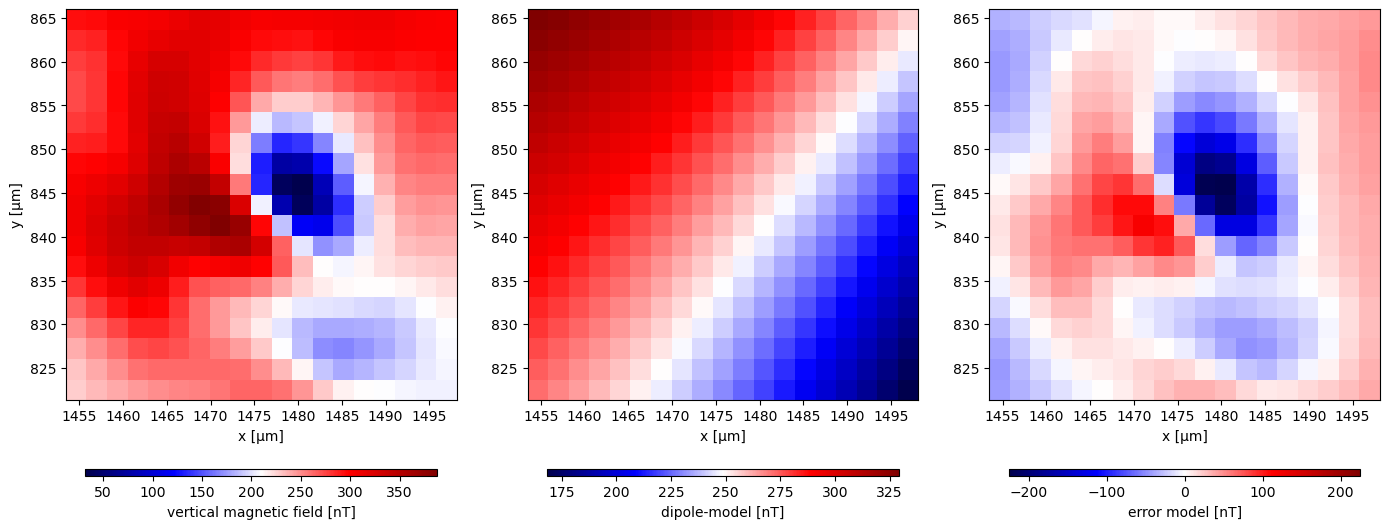

R²: 0.6703417305694374 and SNR: 4.819361162508107


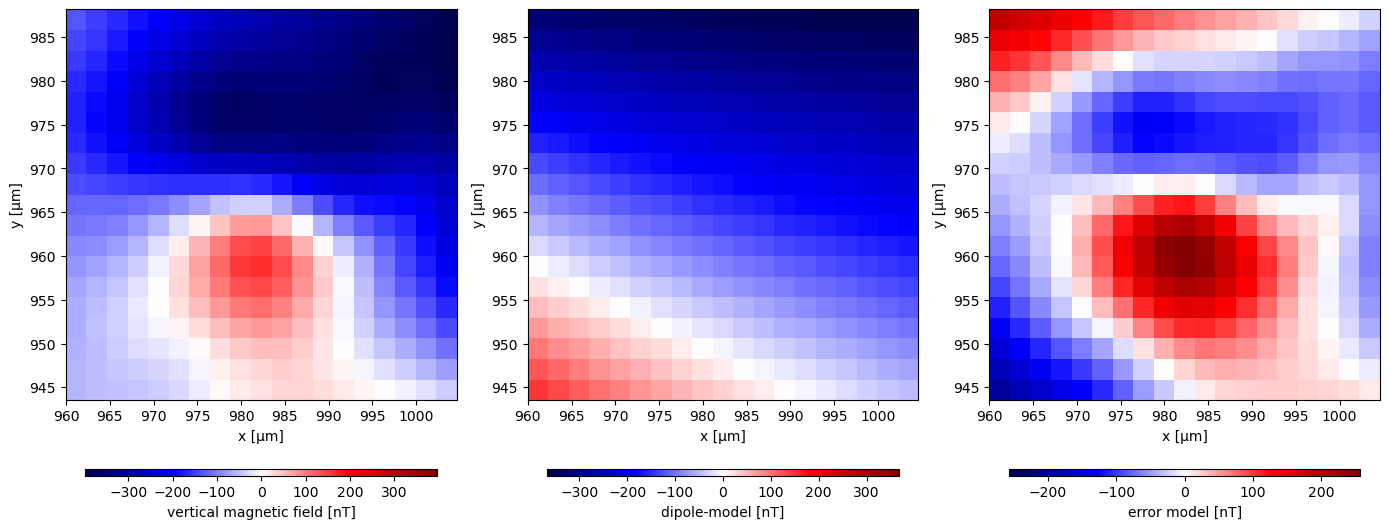

R²: 0.461718459846037 and SNR: 2.6899051621429058


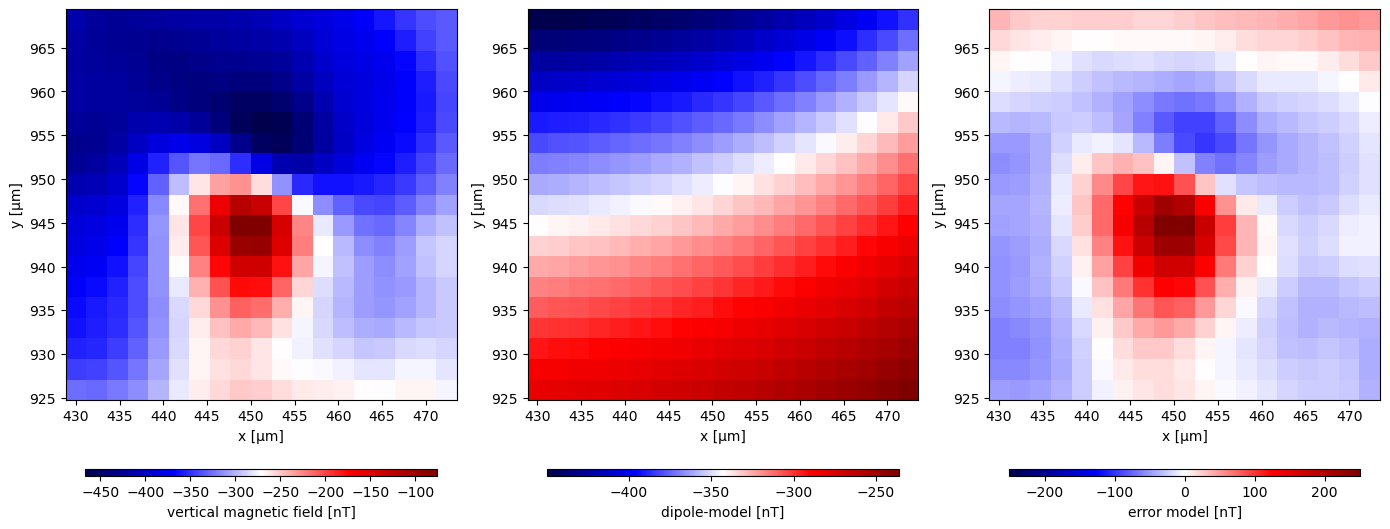

R²: 0.473883507295187 and SNR: 2.789550794350801


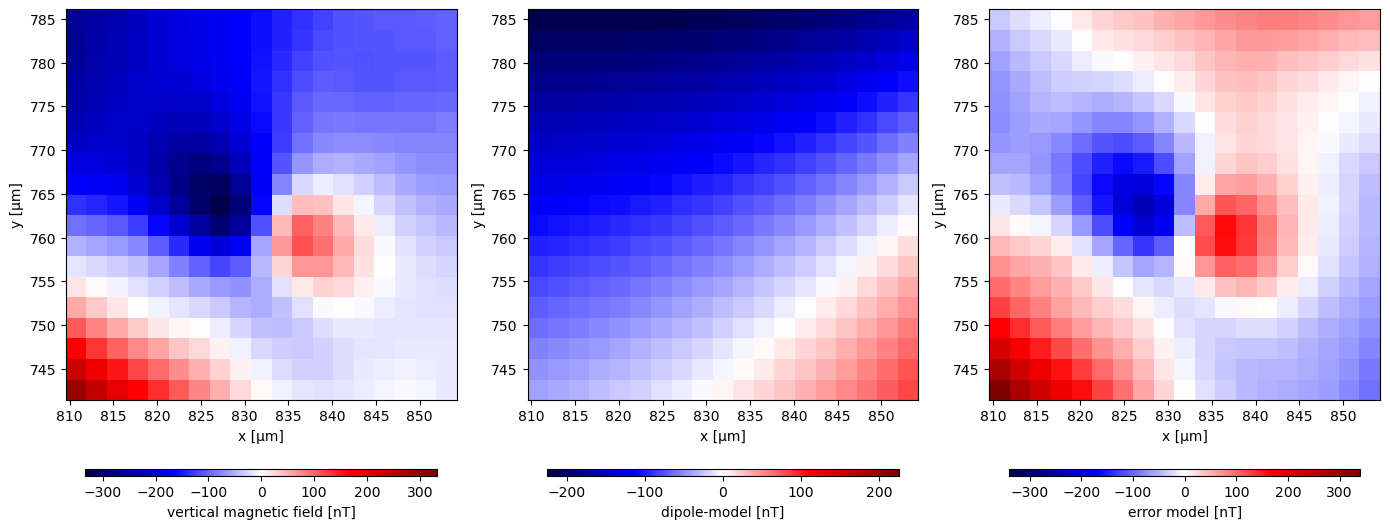

R²: 0.36107944304313777 and SNR: 1.9455314070908711


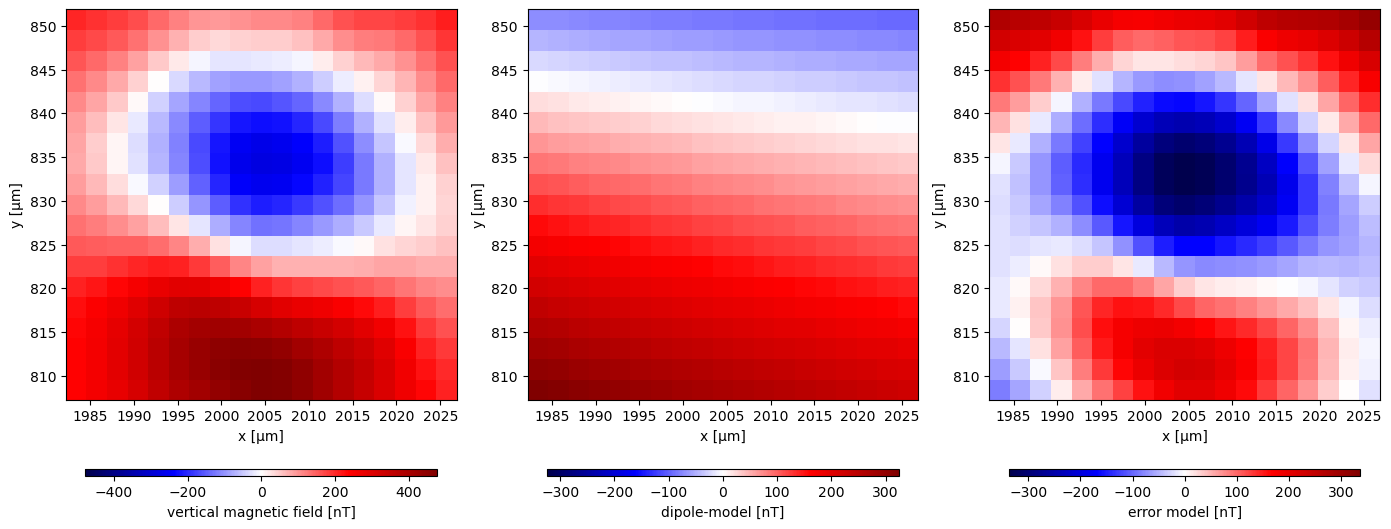

R²: 0.4727441946153309 and SNR: 2.779786299367


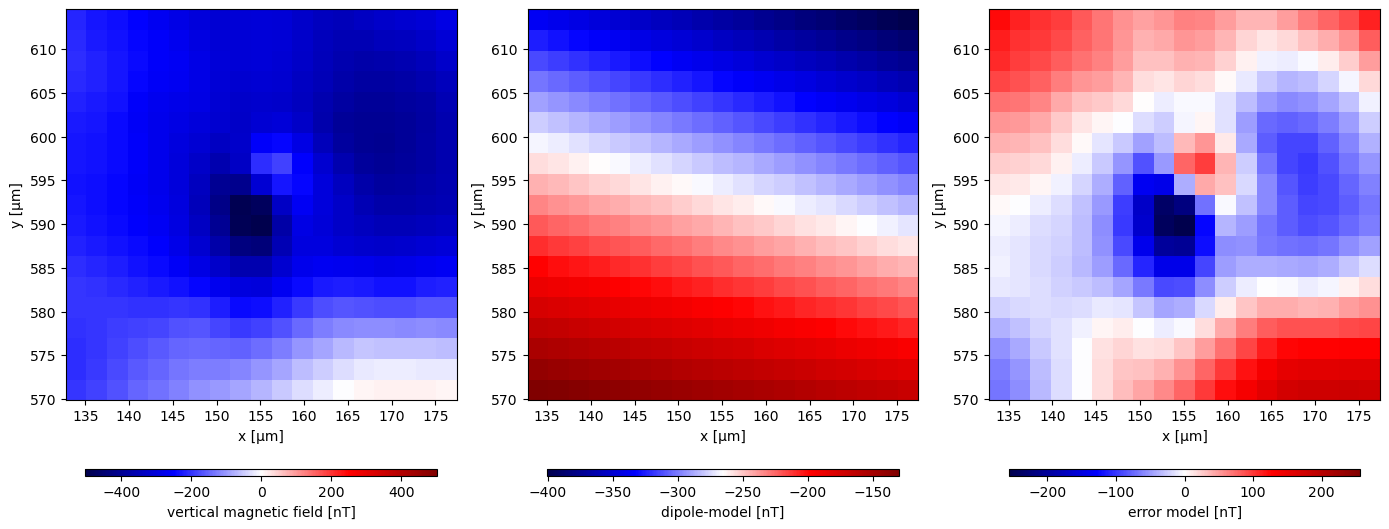

R²: 0.5115352454328181 and SNR: 3.111667675741272


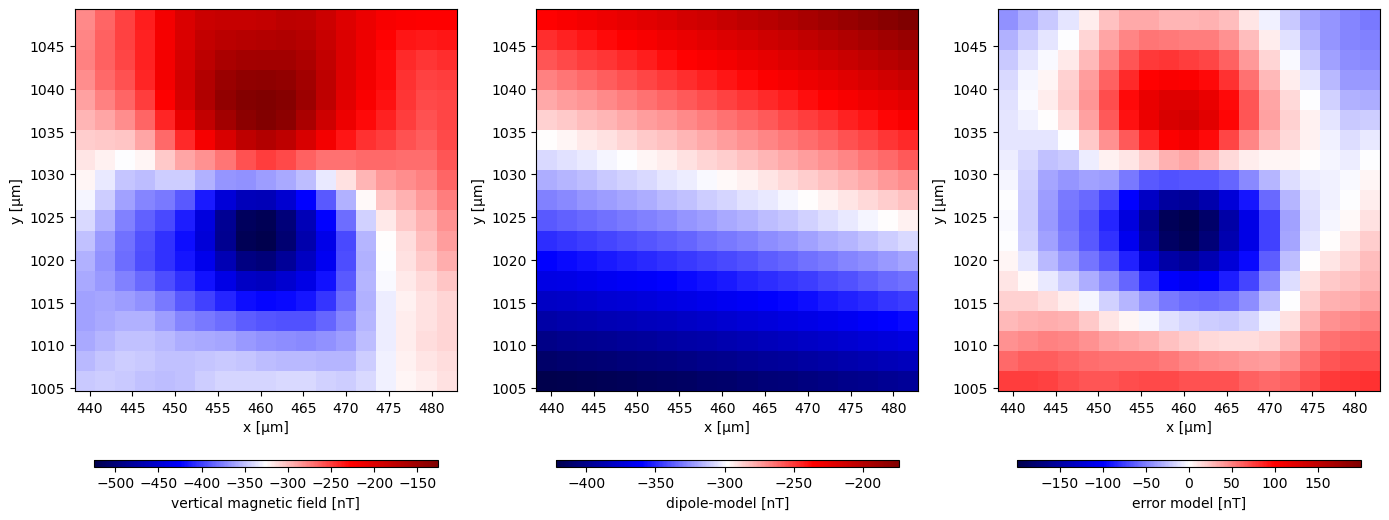

R²: 0.3712451551586139 and SNR: 2.0151907842035977


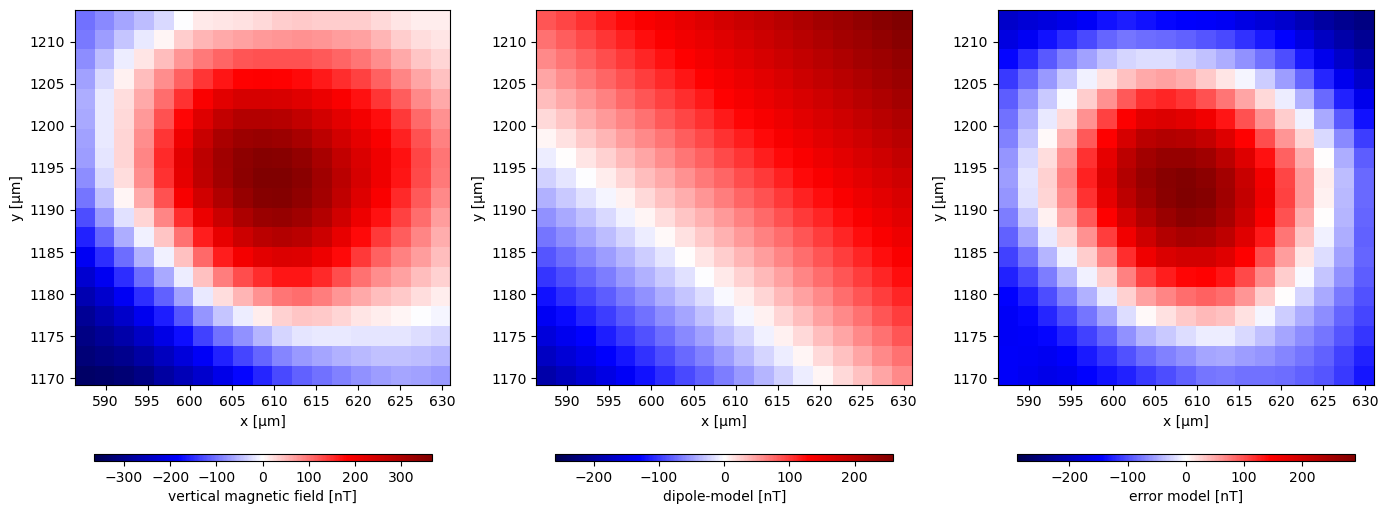

R²: 0.4921501281548788 and SNR: 2.9435378818003017


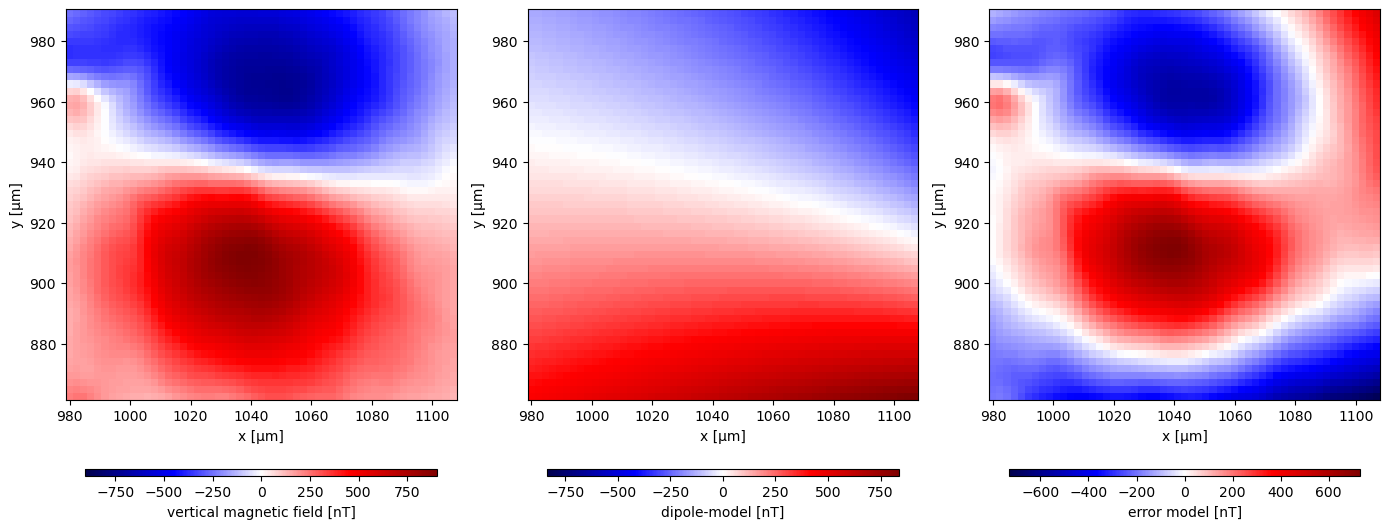

R²: 0.016464477631001673 and SNR: 0.07210070181725126


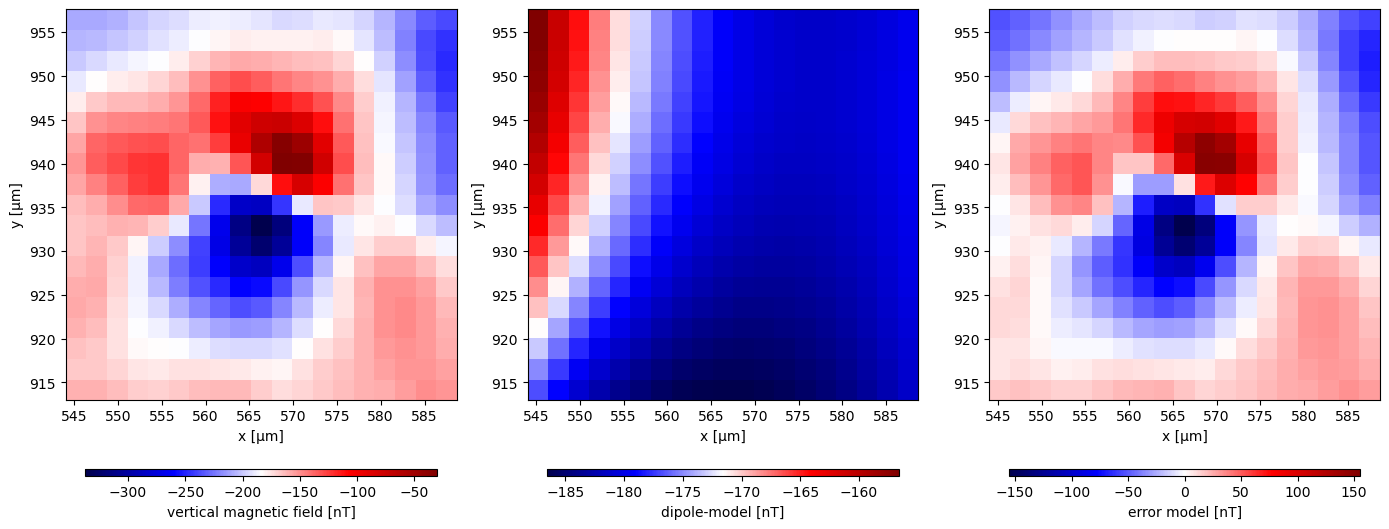

R²: 0.19247384161150316 and SNR: 0.9284358484377921


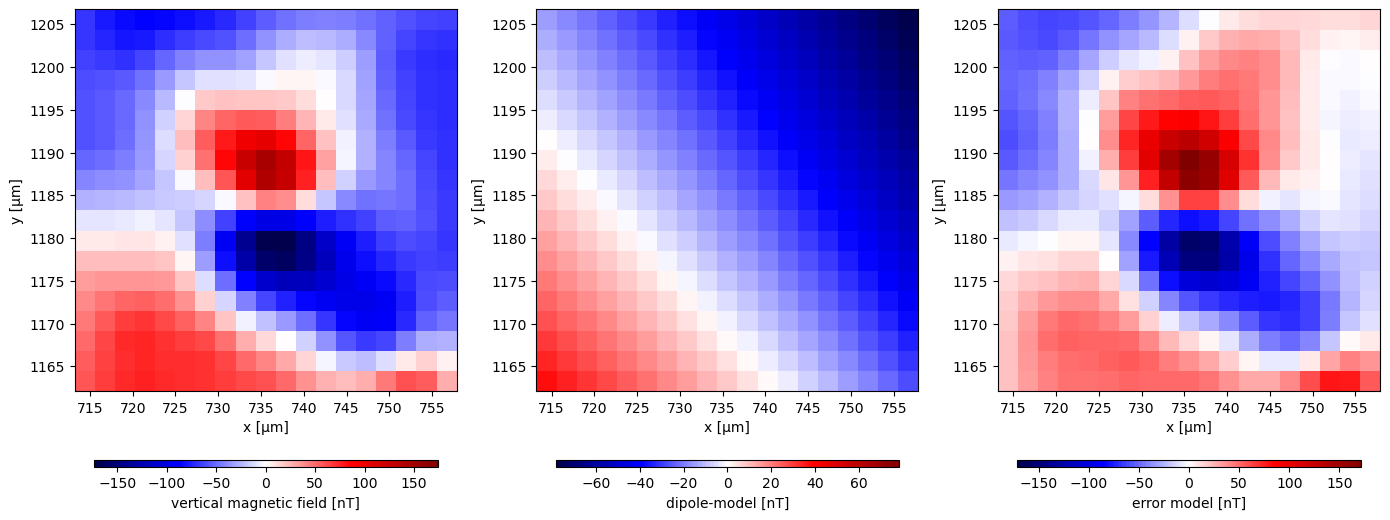

R²: 0.40936720730241793 and SNR: 2.286824895384717


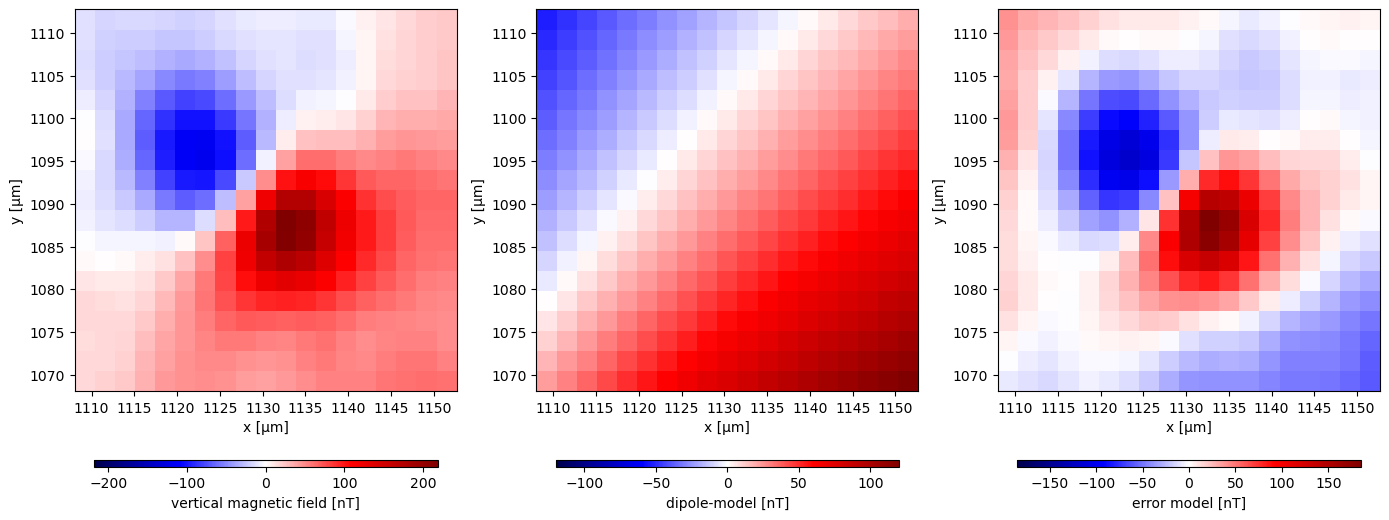

R²: 0.6573814855514402 and SNR: 4.651892157615106


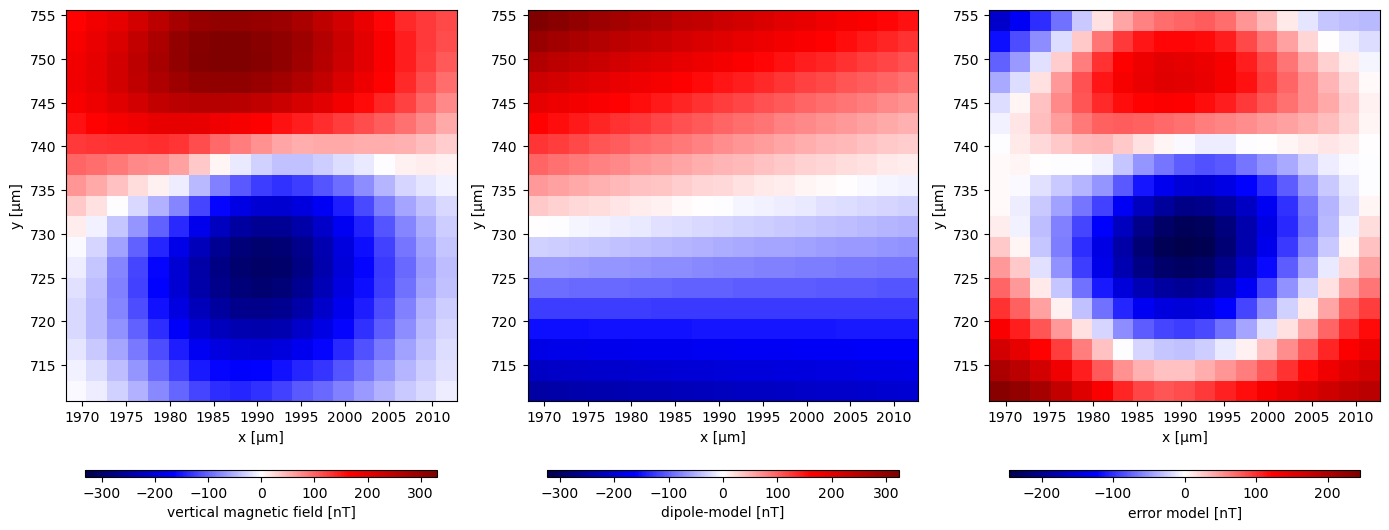

R²: -0.7193750543409327 and SNR: -1.826000757119057


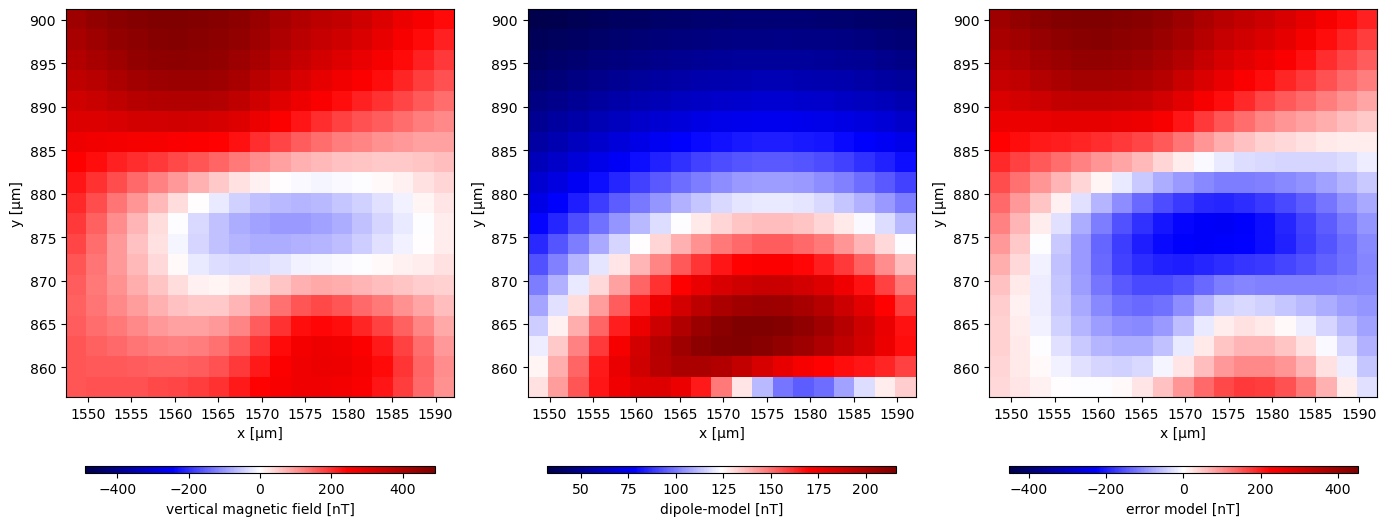

R²: 0.2193923937751341 and SNR: 1.0756726216072112


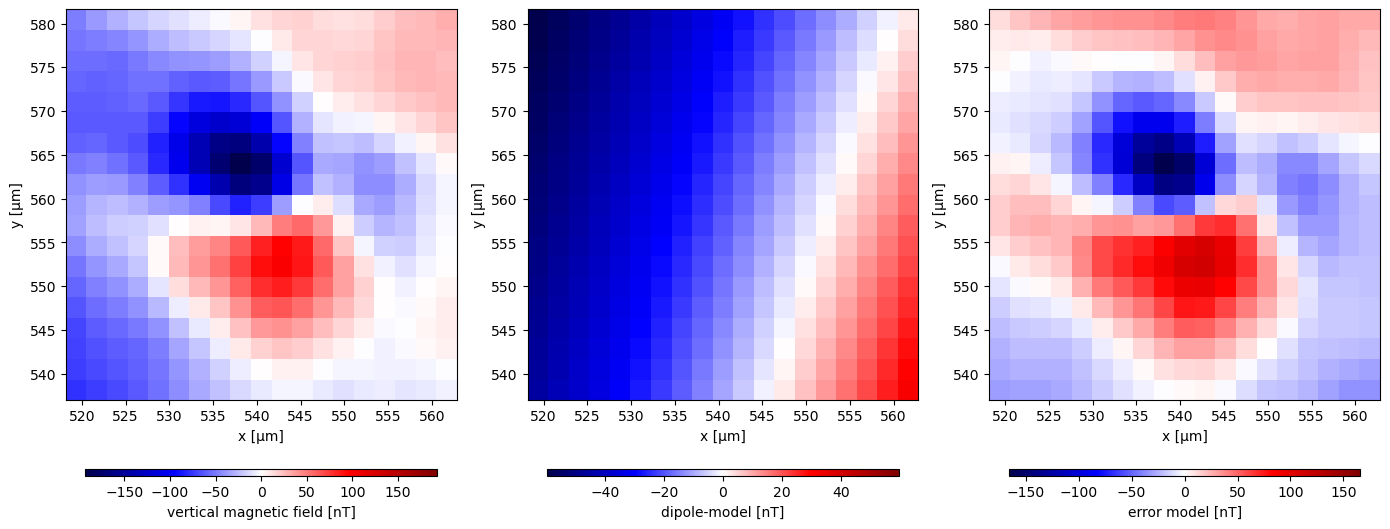

R²: 0.21417207929717608 and SNR: 1.0467284995817652


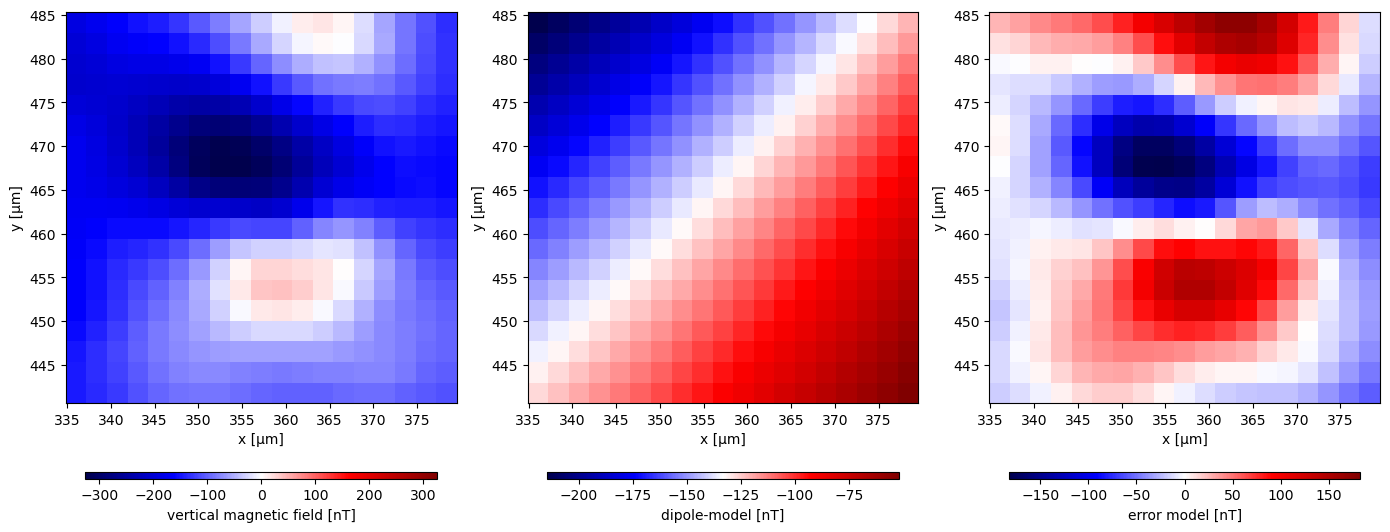

R²: 0.30500649571127036 and SNR: 1.5802199631173104


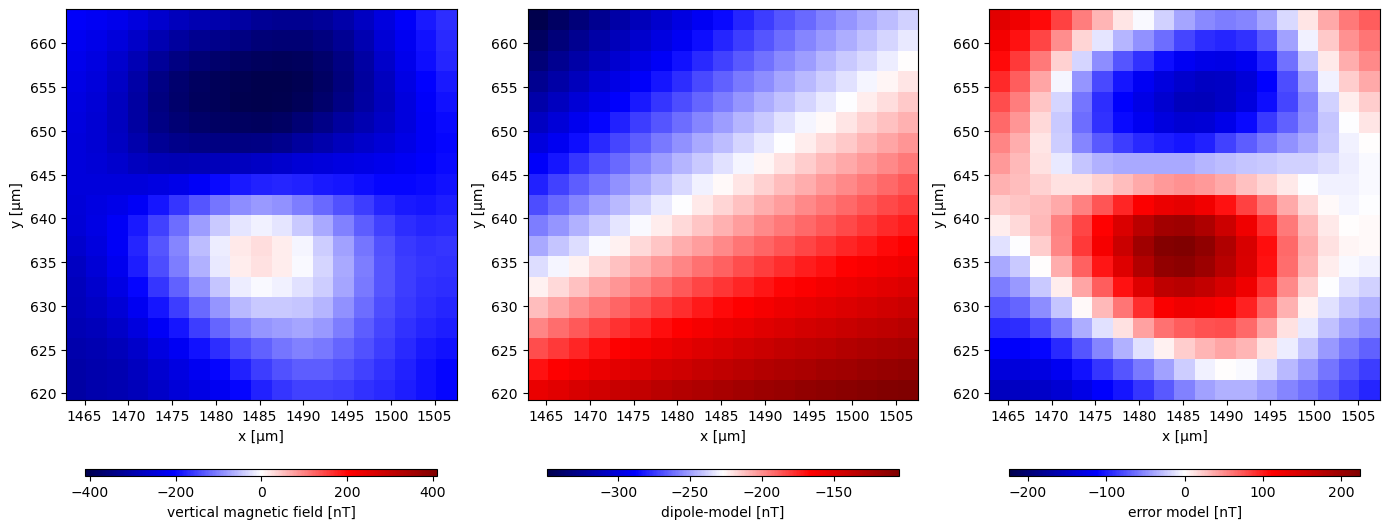

R²: 0.6735402677376516 and SNR: 4.86171273412347


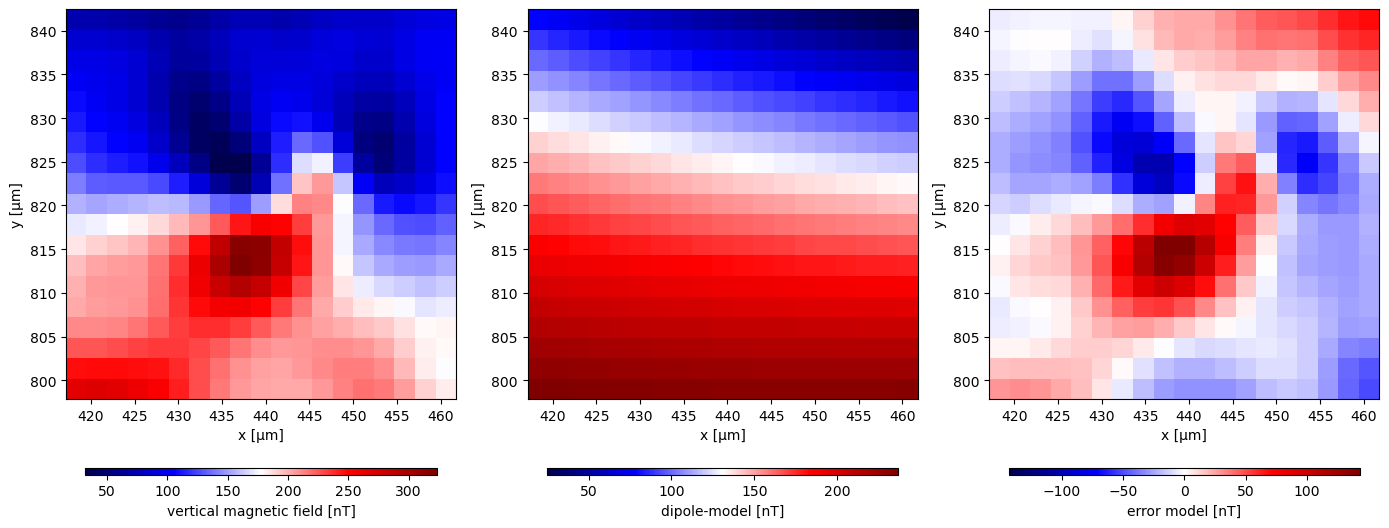

R²: 0.646471171658835 and SNR: 4.518561519354315


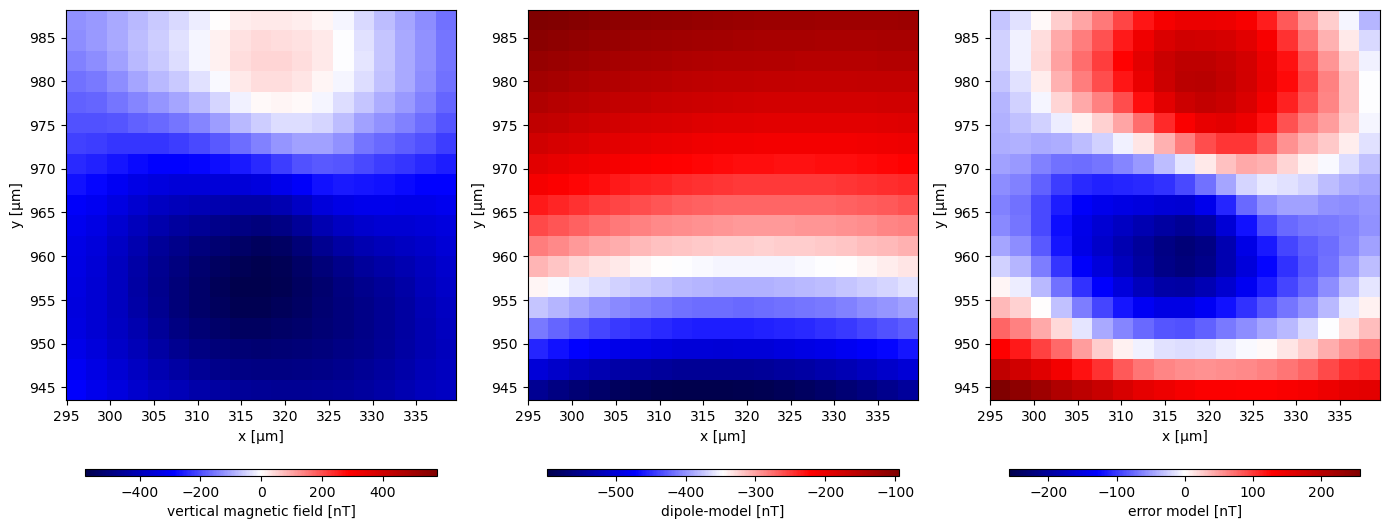

R²: 0.24979291326355202 and SNR: 1.2481886962933413


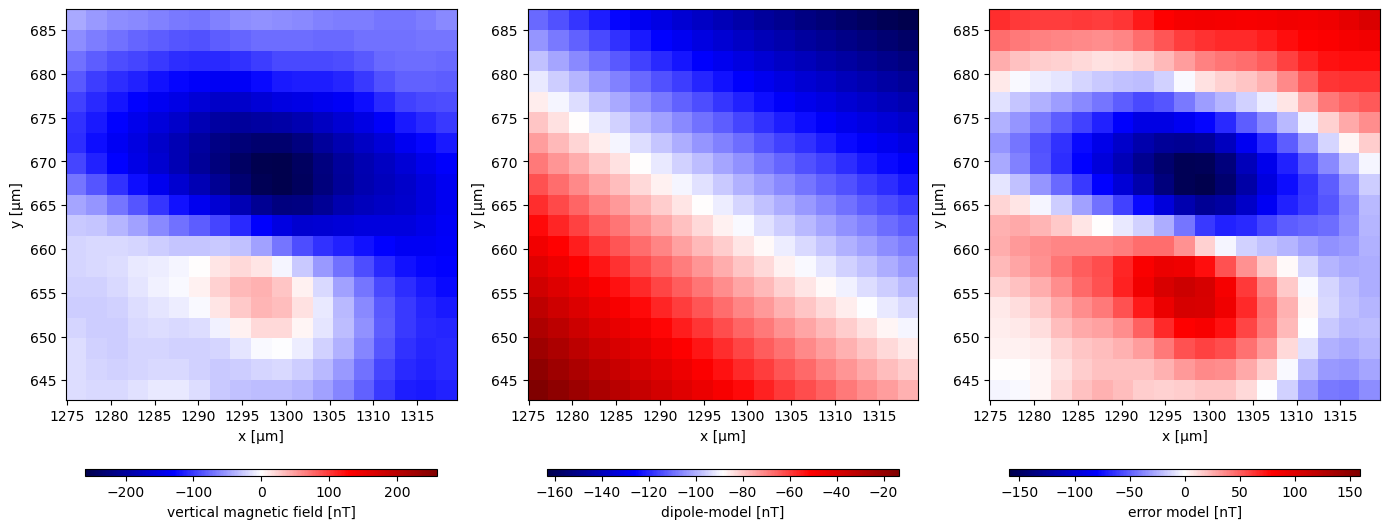

R²: 0.5111907618875433 and SNR: 3.1086997191037753


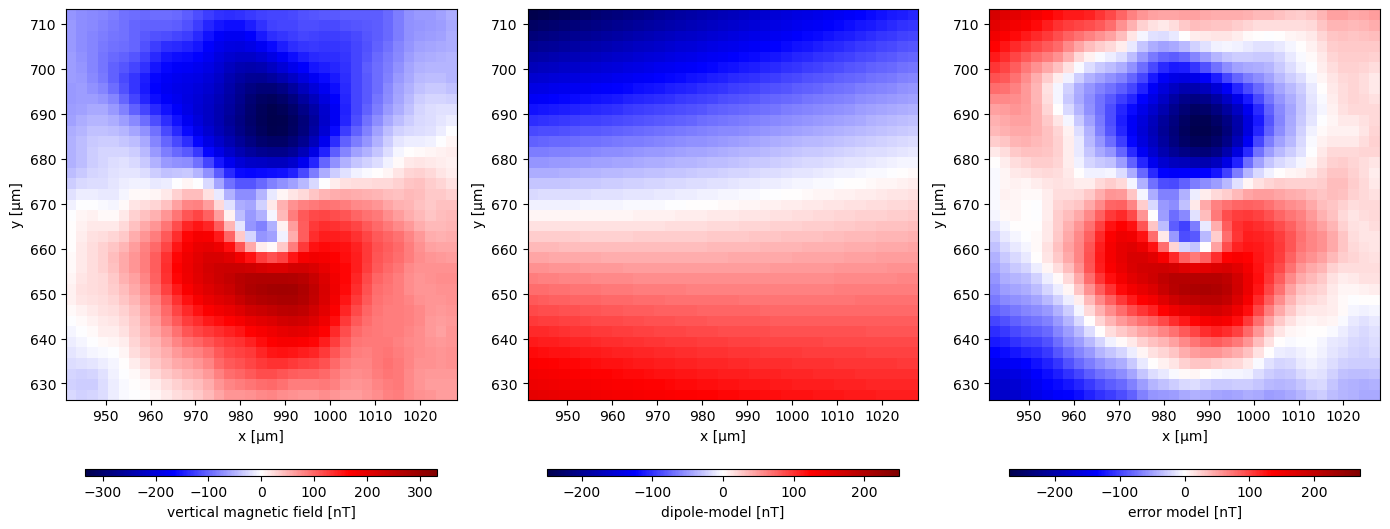

R²: 0.03401722671250562 and SNR: 0.15030681237344354


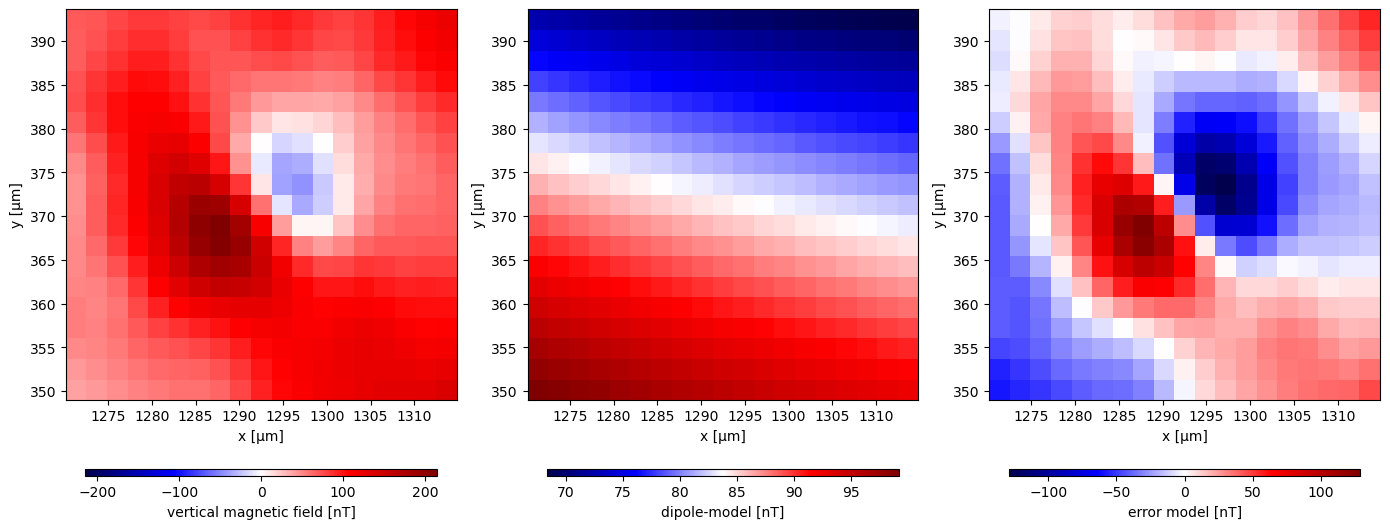

R²: 0.48366029051383364 and SNR: 2.870652811961294


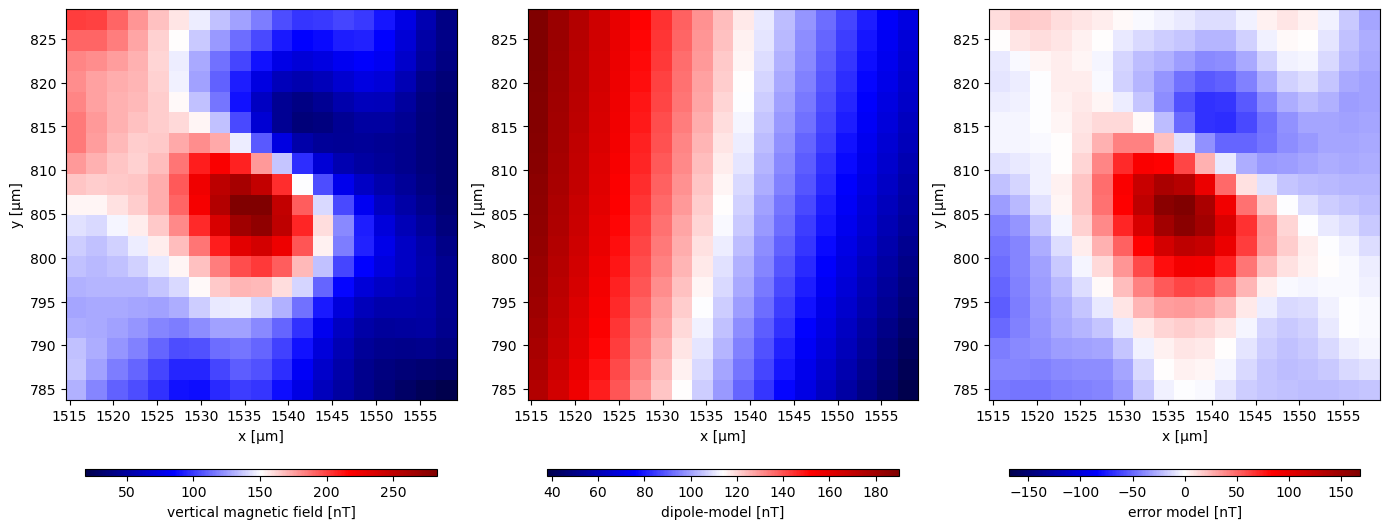

R²: 0.6139535212074101 and SNR: 4.133605254402078


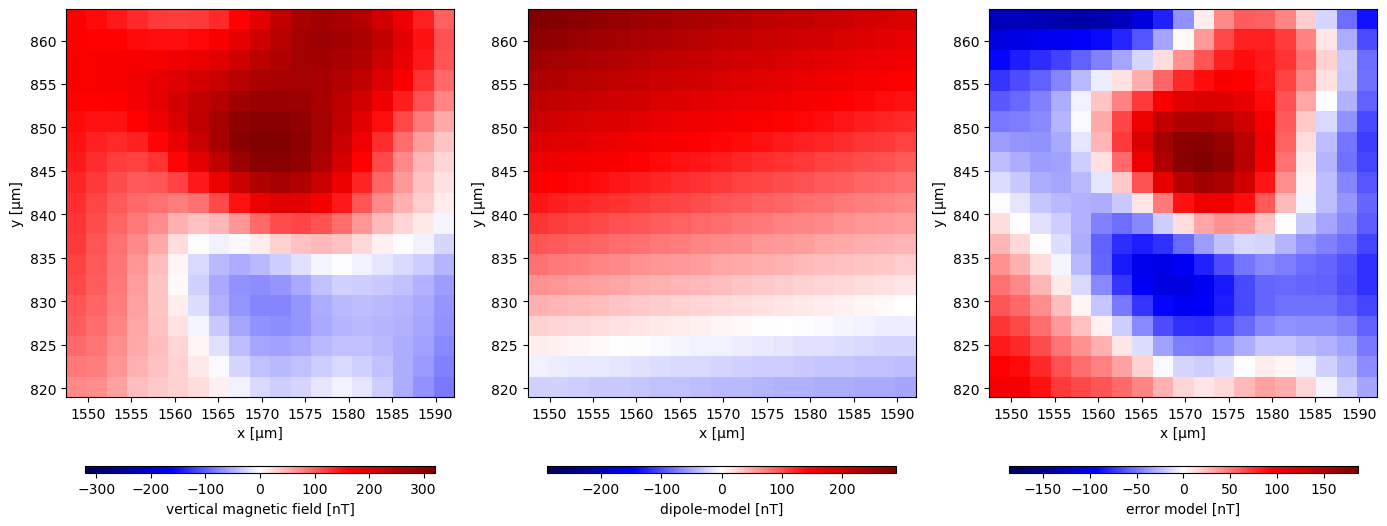

R²: -0.041039951203791336 and SNR: -0.16593981529741234


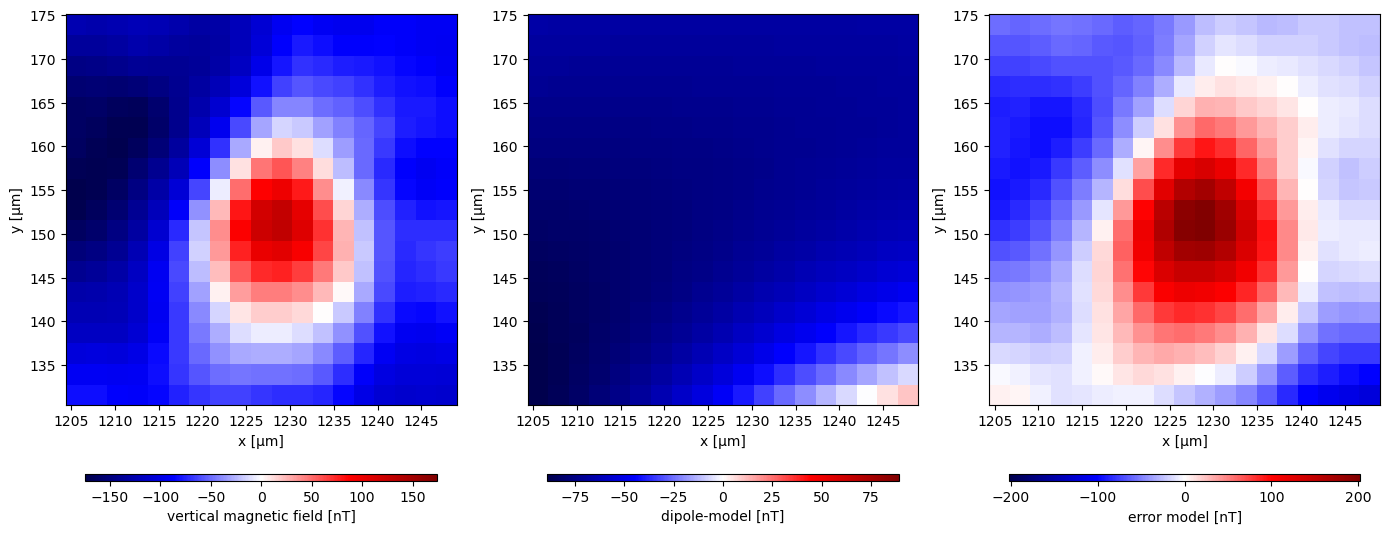

R²: 0.18286628245921566 and SNR: 0.877068692402762


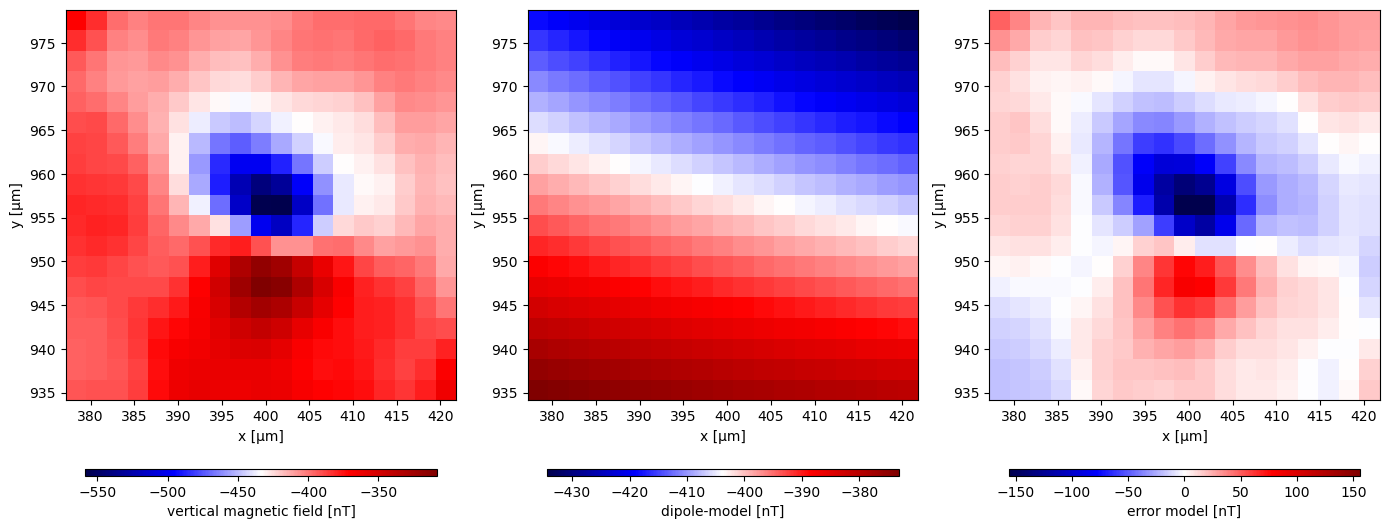

R²: 0.04499791863517022 and SNR: 0.19995823541579466


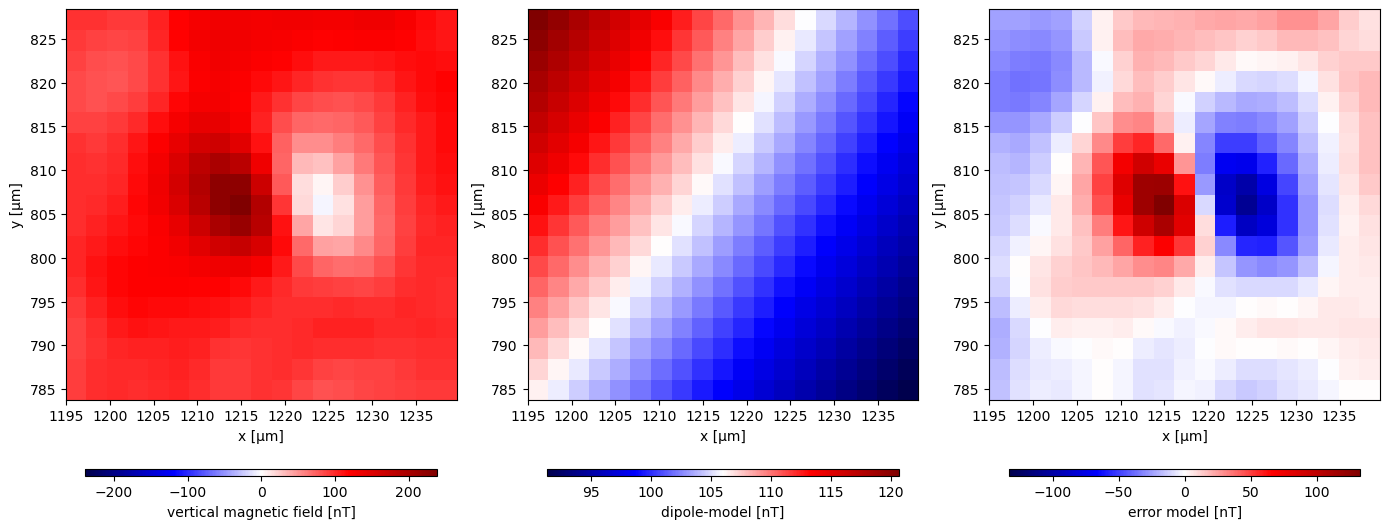

R²: 0.015906686175199414 and SNR: 0.06963719080257864


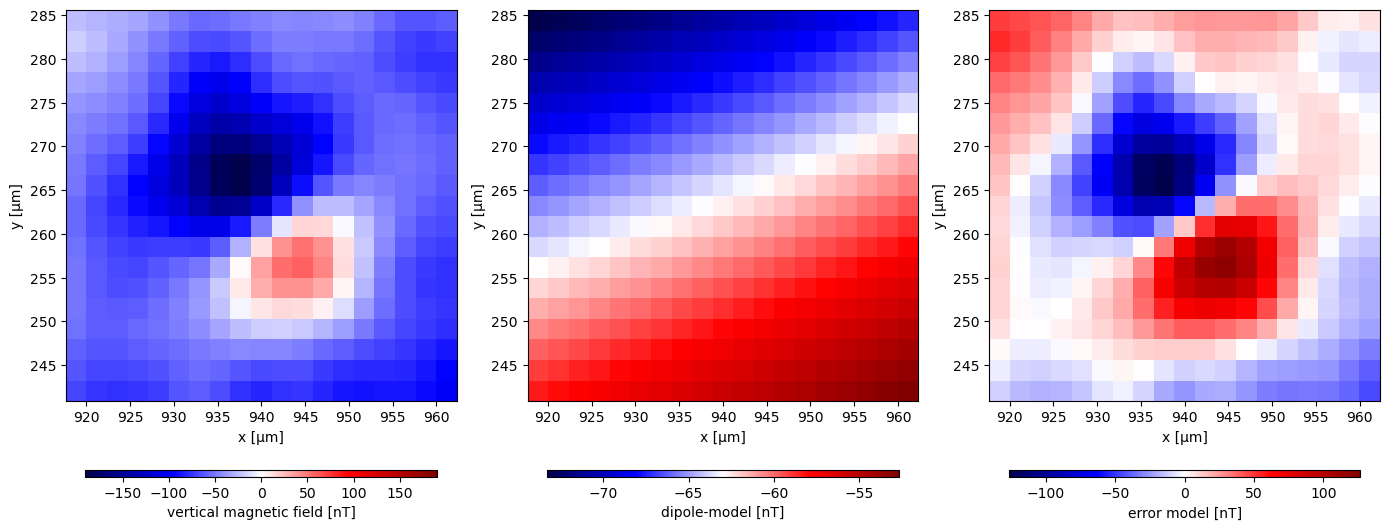

R²: 0.6310556184343472 and SNR: 4.330399952523639


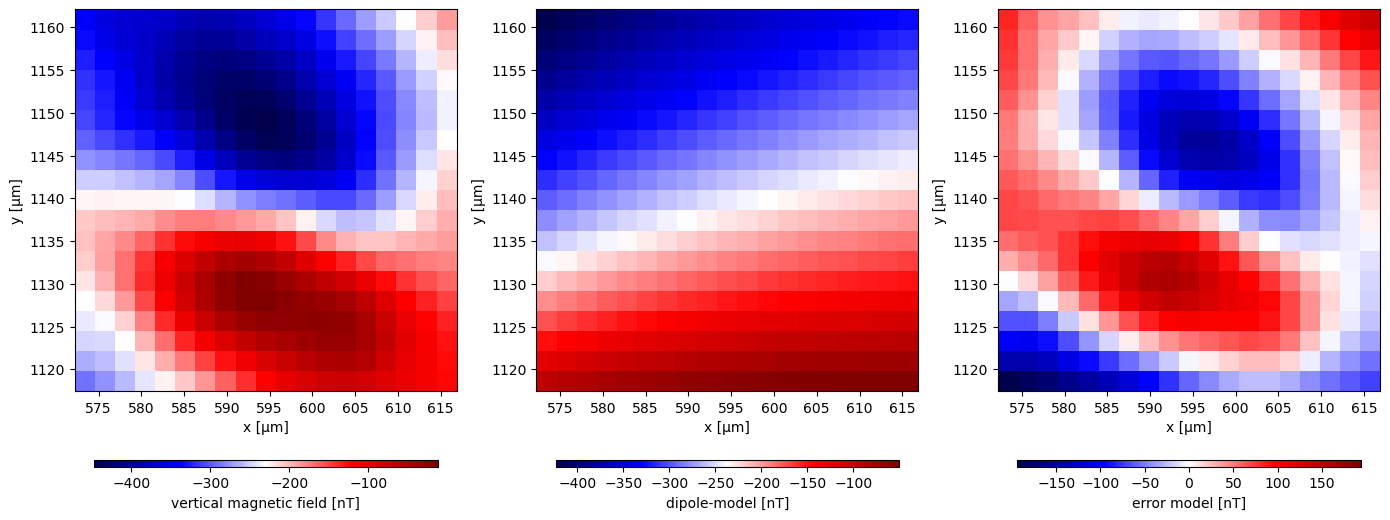

R²: 0.059409737963877274 and SNR: 0.2659984542834123


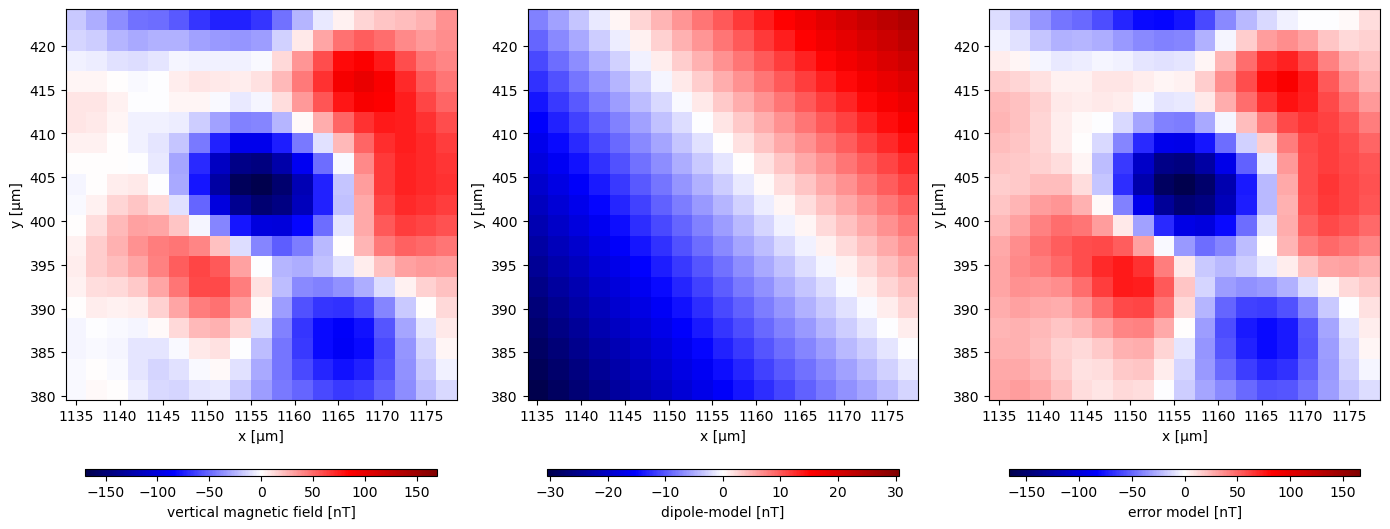

R²: 0.8317344142668937 and SNR: 7.740047627356514


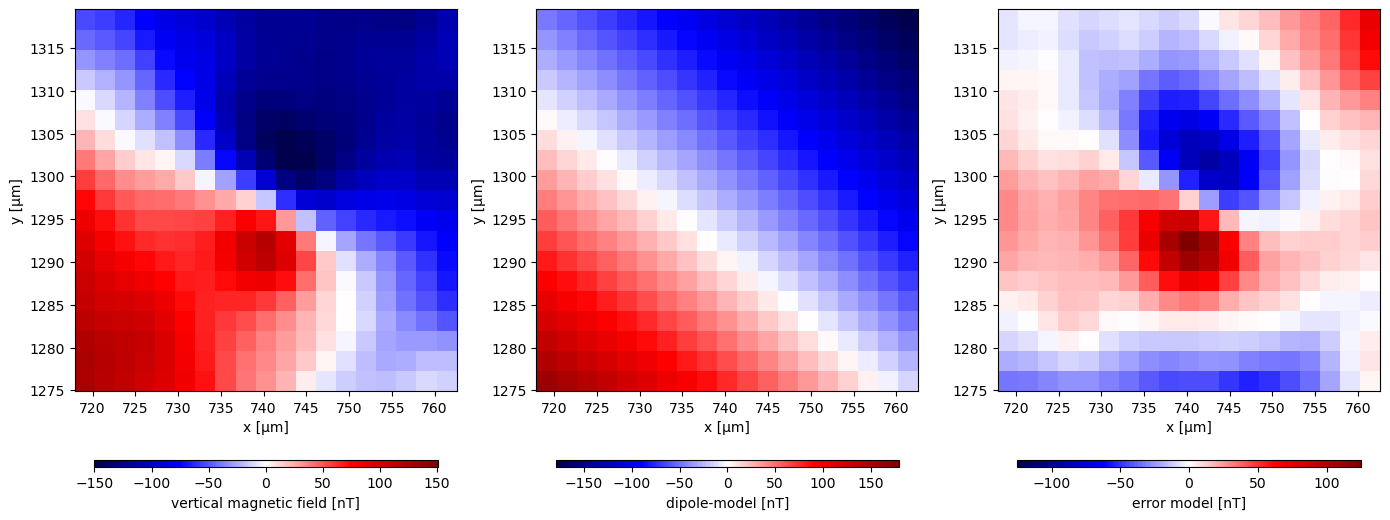

R²: 0.7368688597718581 and SNR: 5.798369439948841


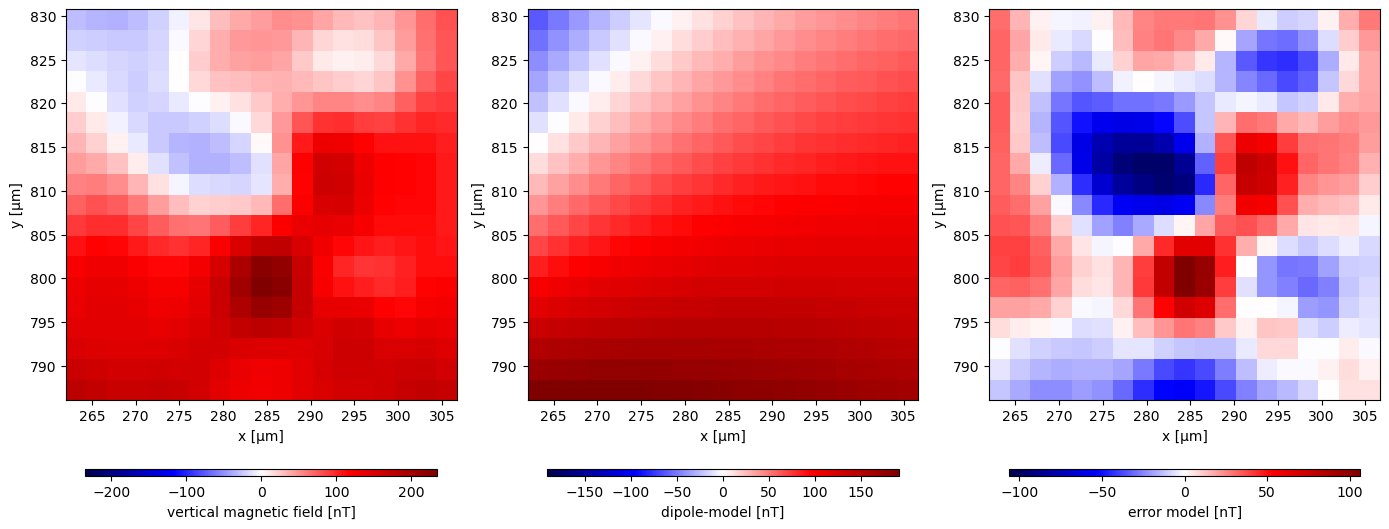

R²: 0.2578874590567184 and SNR: 1.2953023022571877


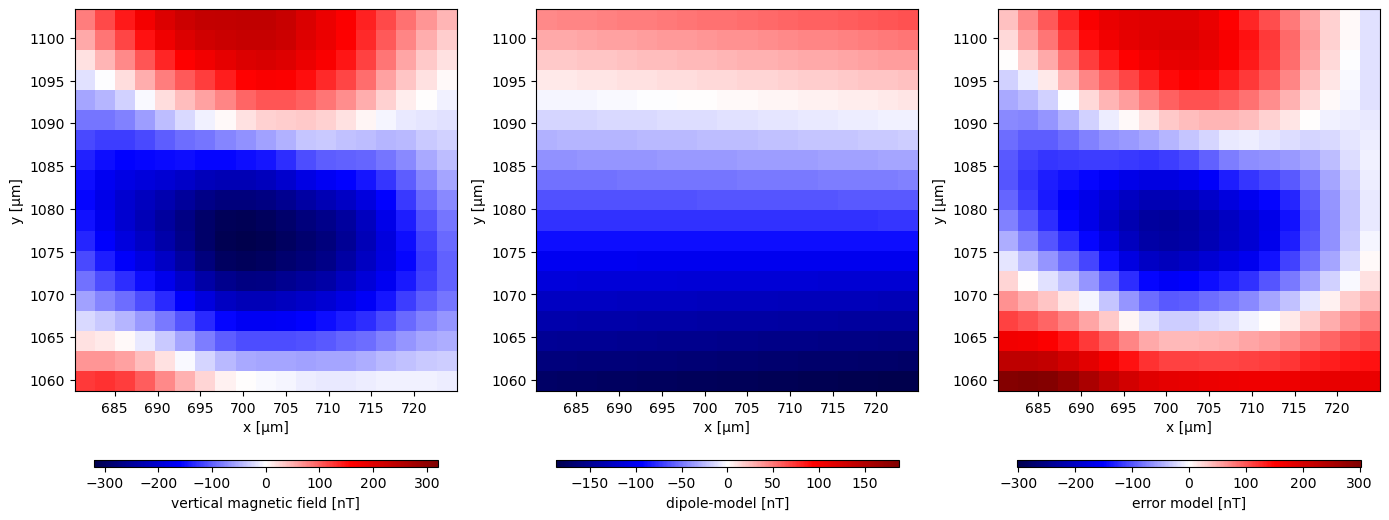

R²: 0.35883951125243974 and SNR: 1.9303330355191115


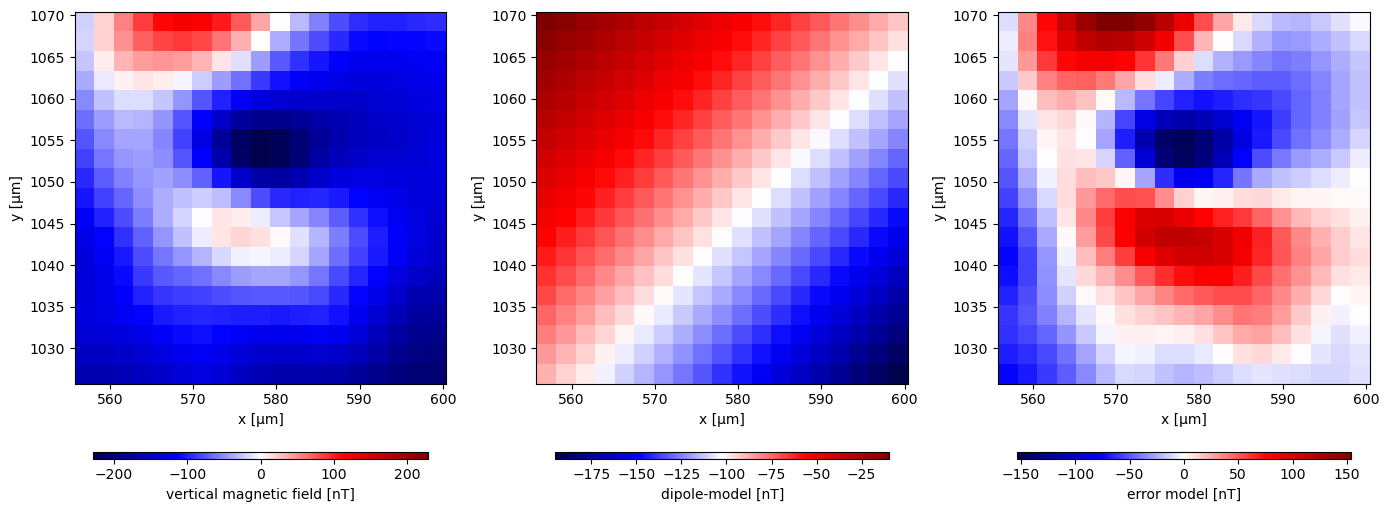

R²: 0.1183418908540218 and SNR: 0.5469984722975386


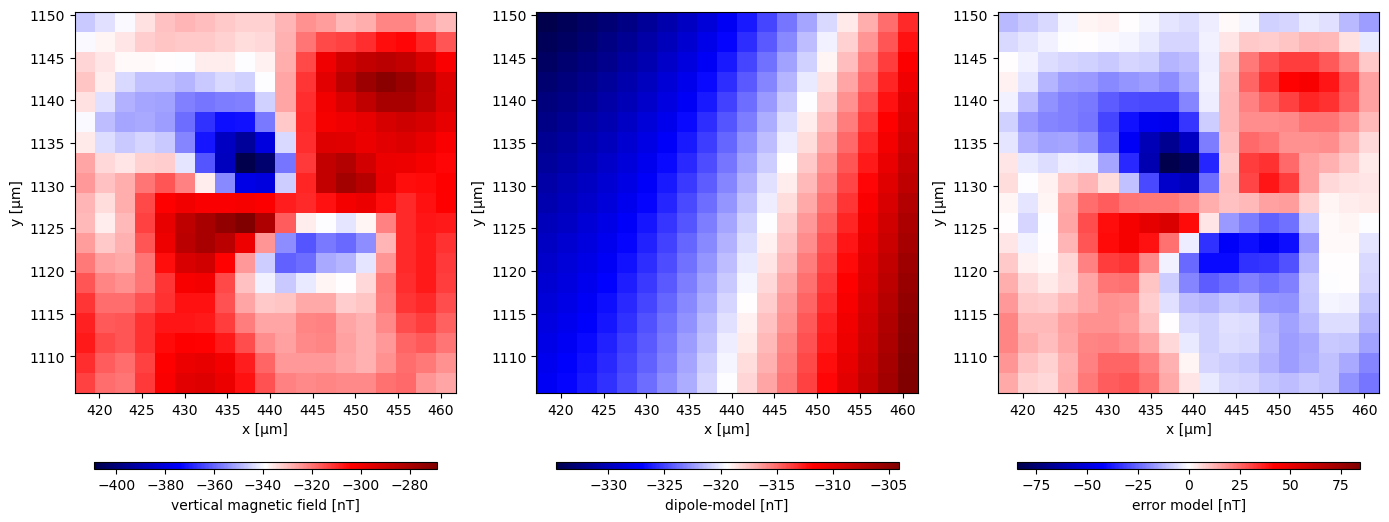

R²: 0.3135107326024701 and SNR: 1.6336660090450537


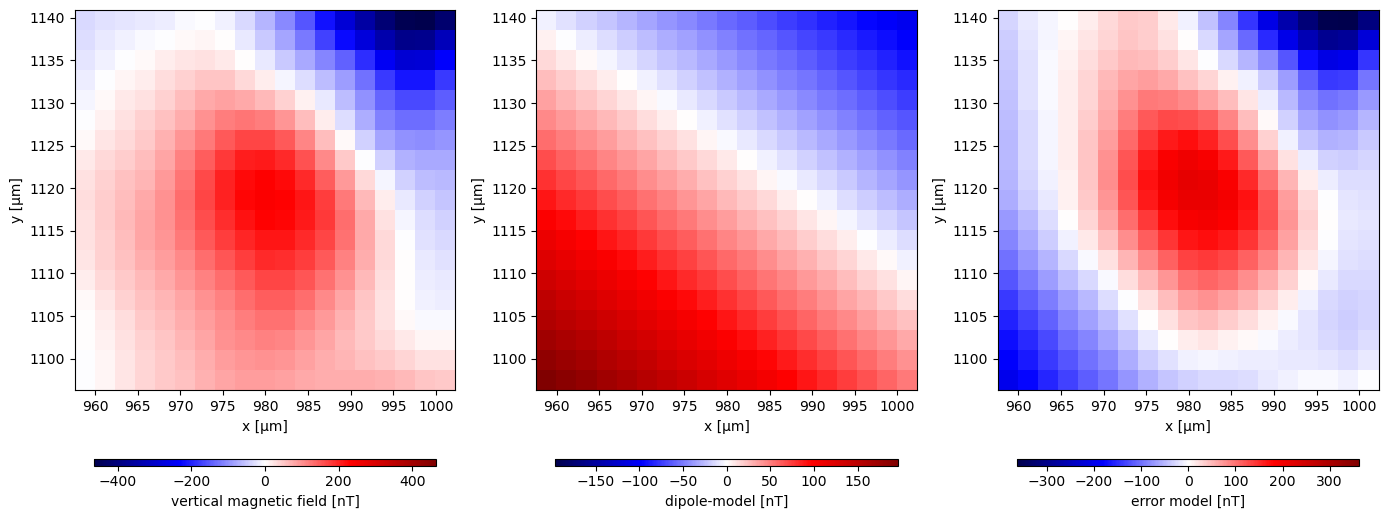

R²: 0.4464139622988853 and SNR: 2.56814932582645


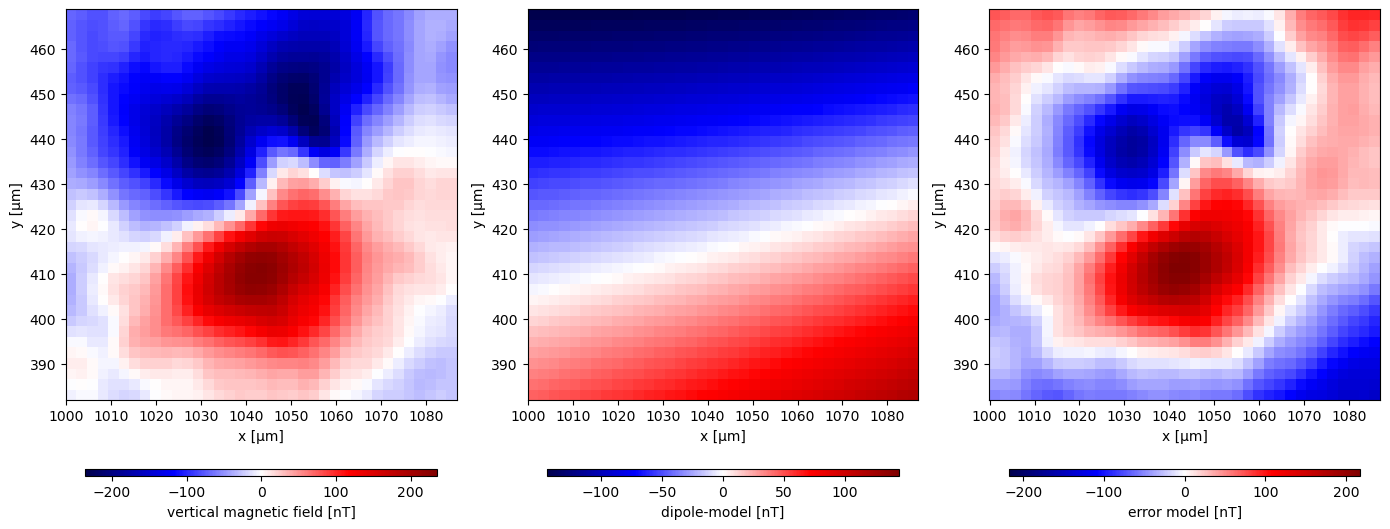

R²: 0.06866103275338908 and SNR: 0.30892301649359044


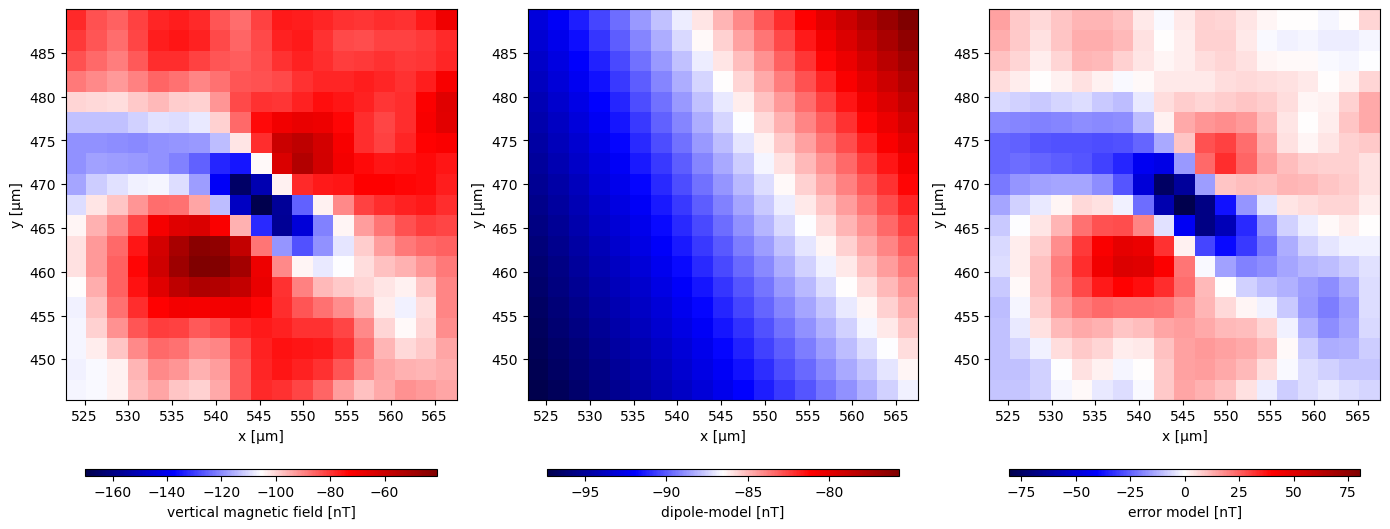

R²: 0.49493895289195977 and SNR: 2.9665700229231606


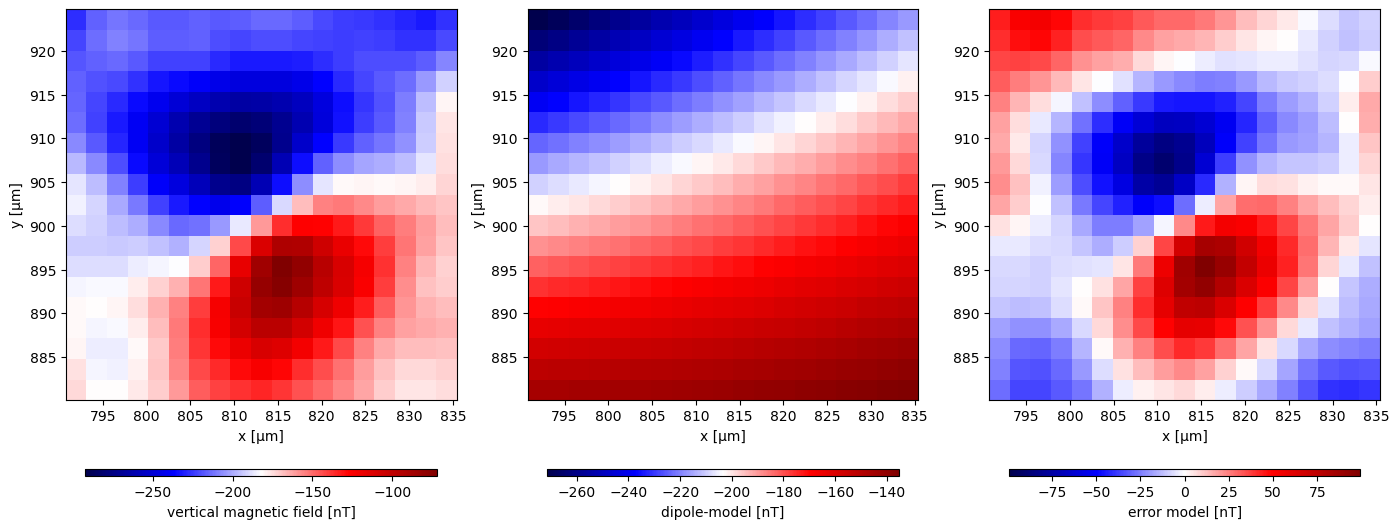

R²: 0.8574352739392104 and SNR: 8.459880448483608


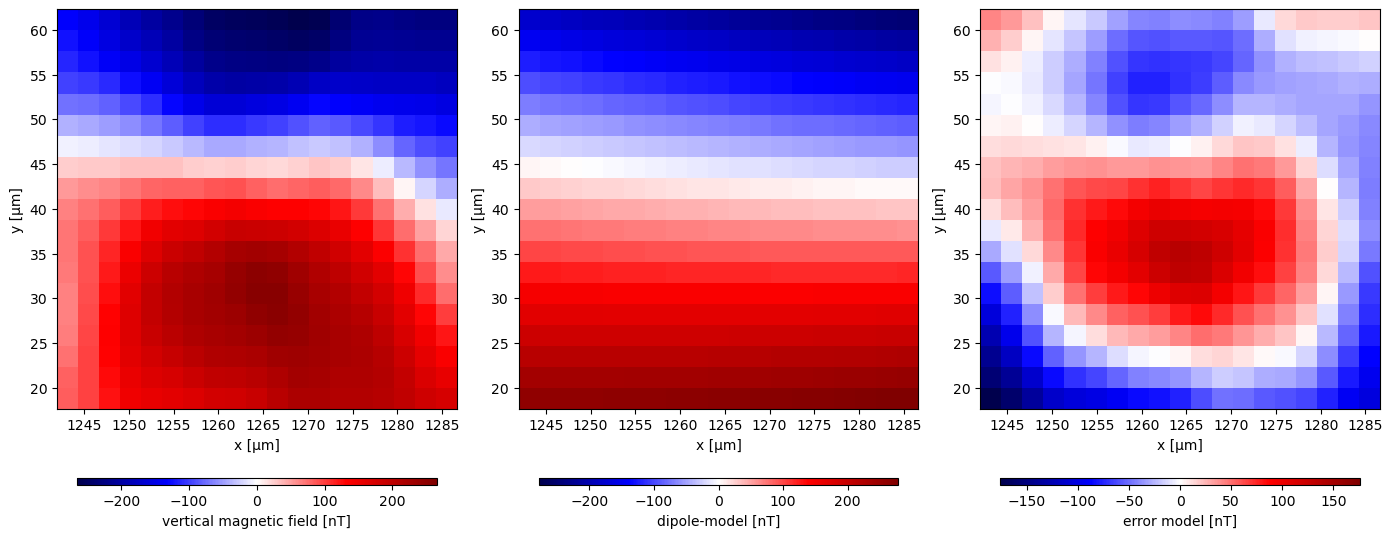

R²: 0.923740783417721 and SNR: 11.177076666187759


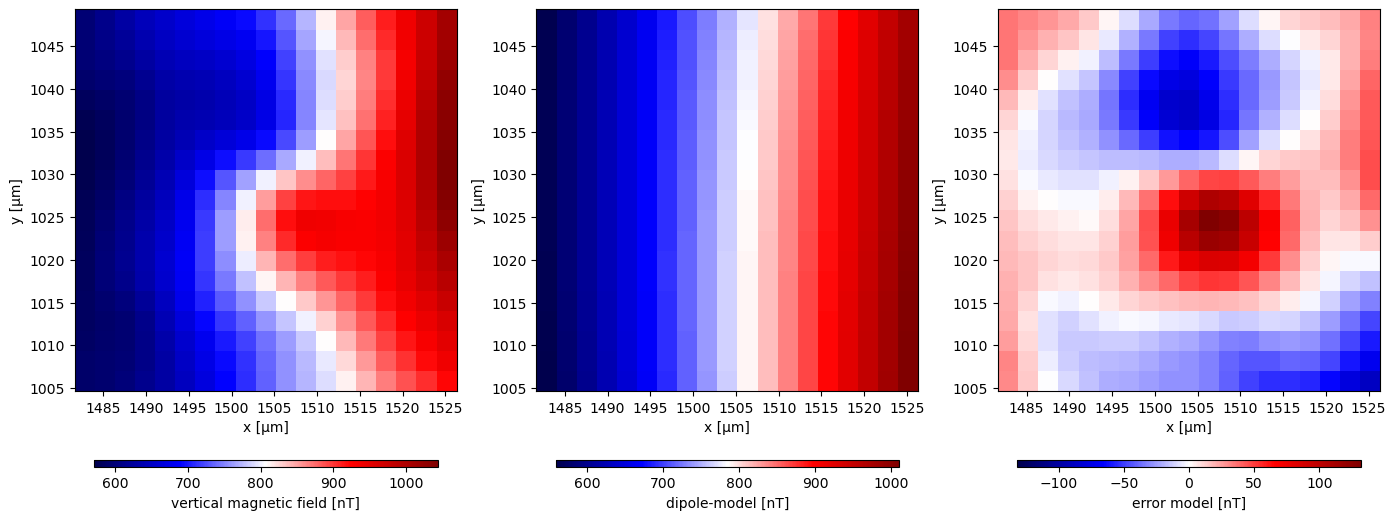

R²: -0.013990201637656074 and SNR: 0.006986455974142649


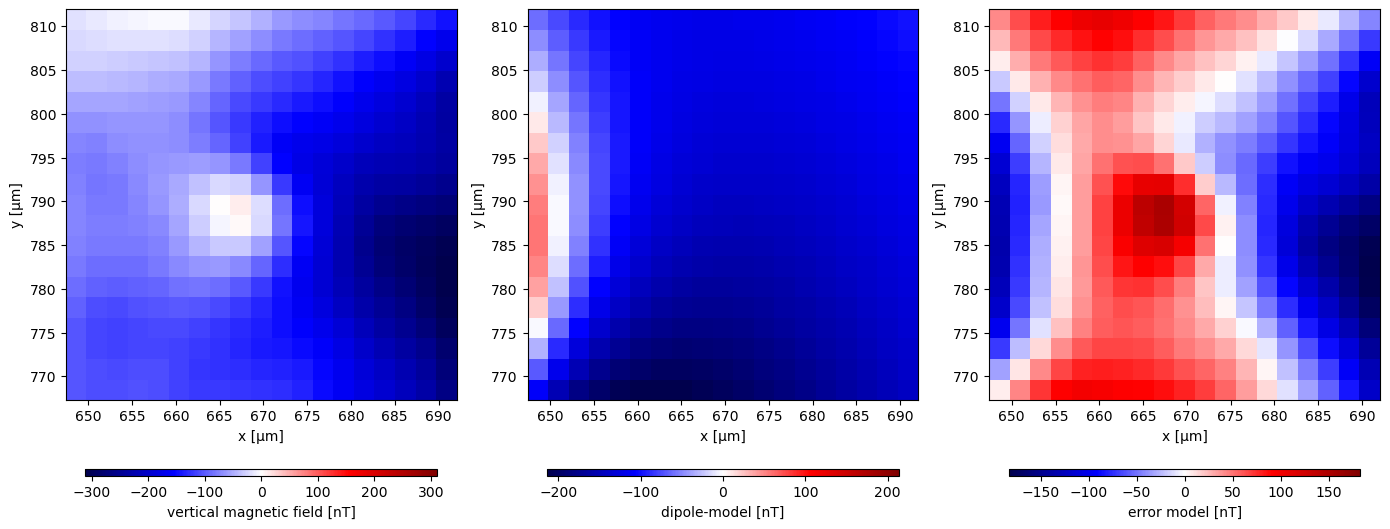

R²: 0.4620386719492878 and SNR: 2.692489771510496


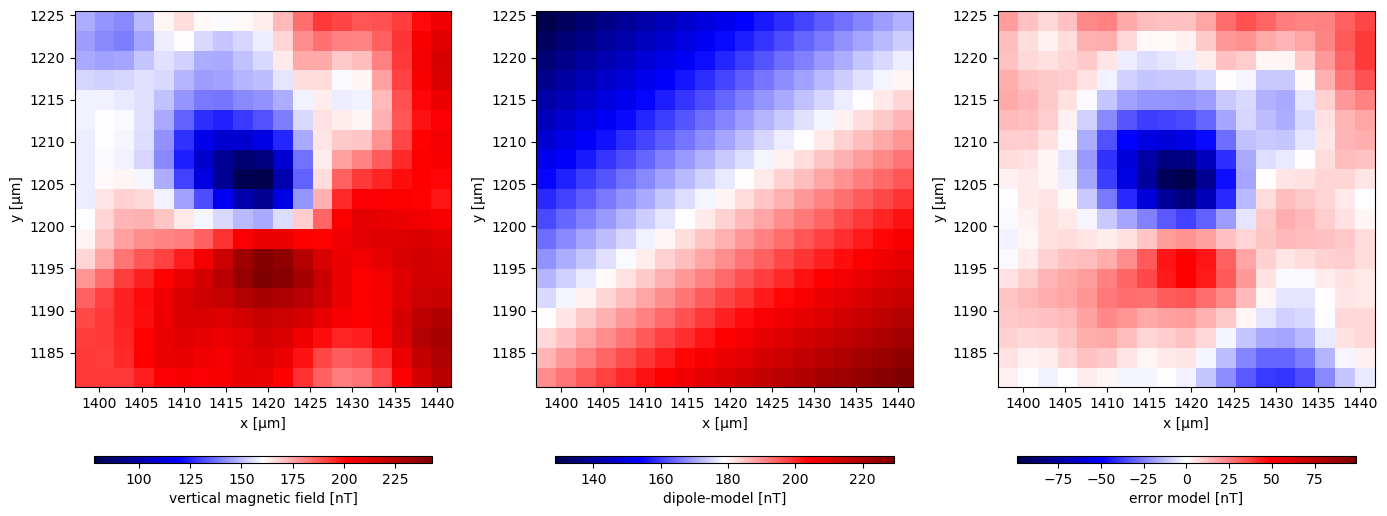

R²: 0.25900106069259576 and SNR: 1.302882930207803


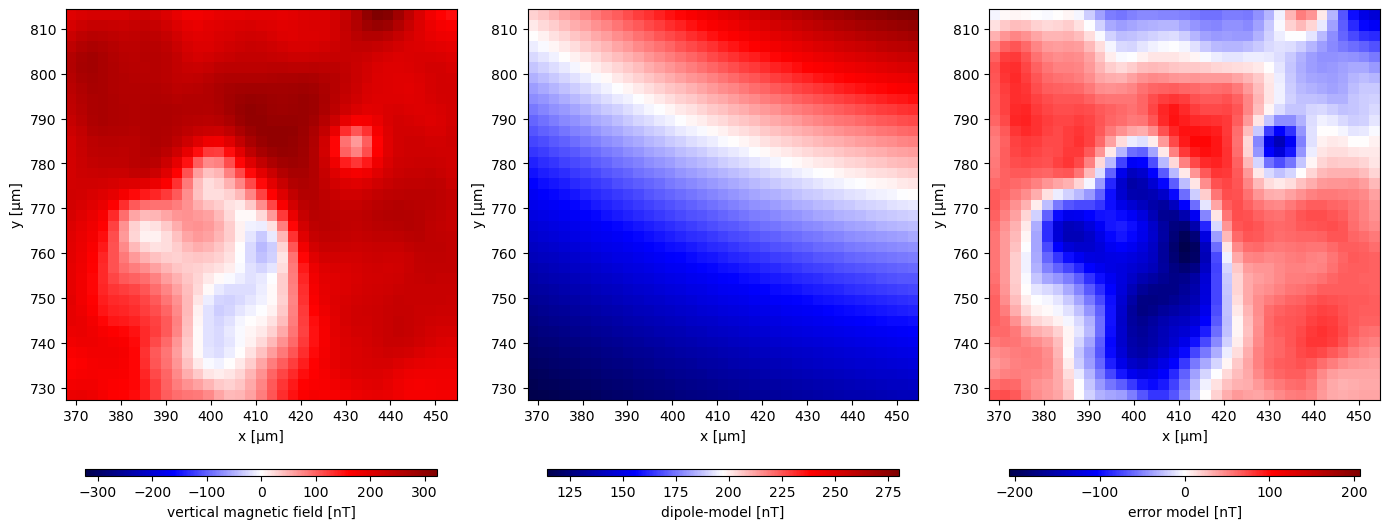

R²: 0.632678315744735 and SNR: 4.34957461651715


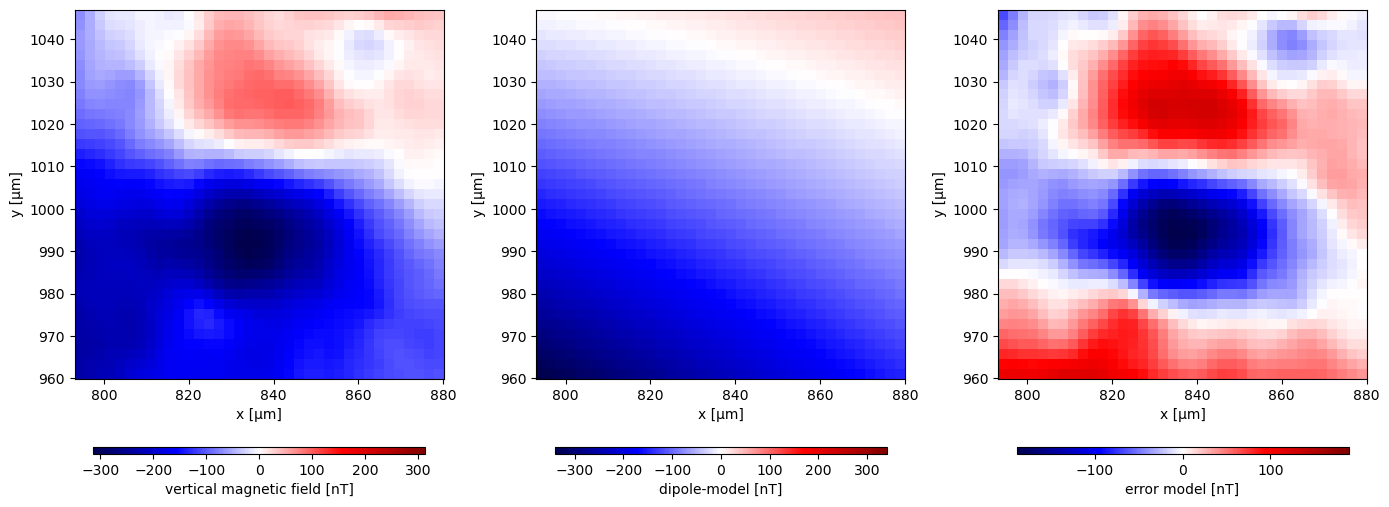

R²: 0.7729218169973708 and SNR: 6.438286134426146


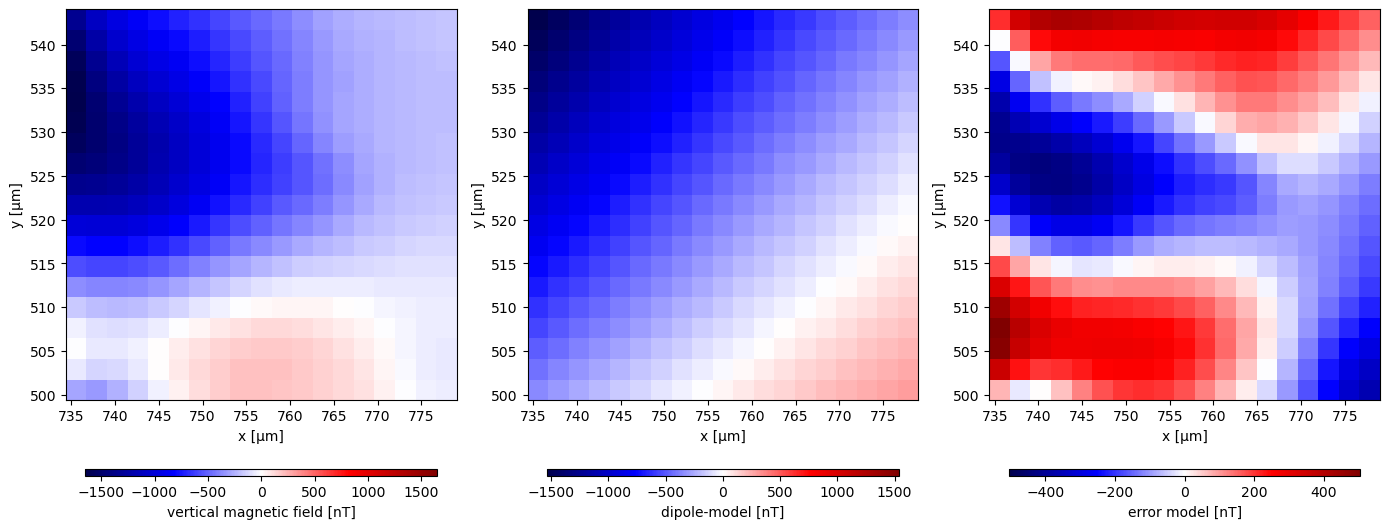

R²: 0.4758495291178352 and SNR: 2.805440997606615


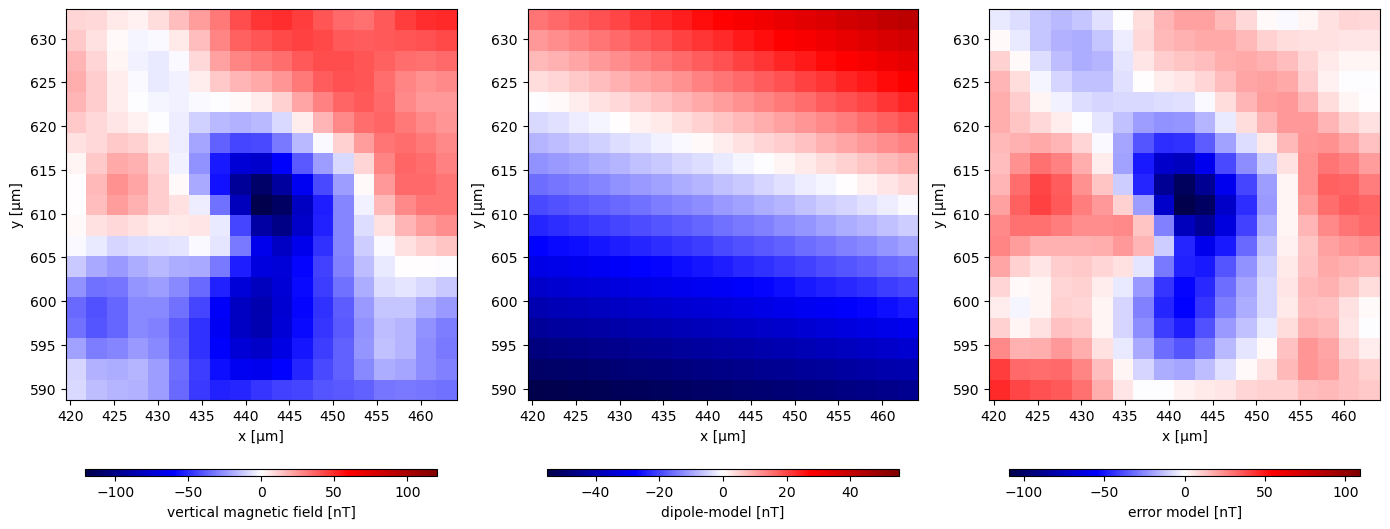

R²: 0.5522436684926602 and SNR: 3.4895831271418203


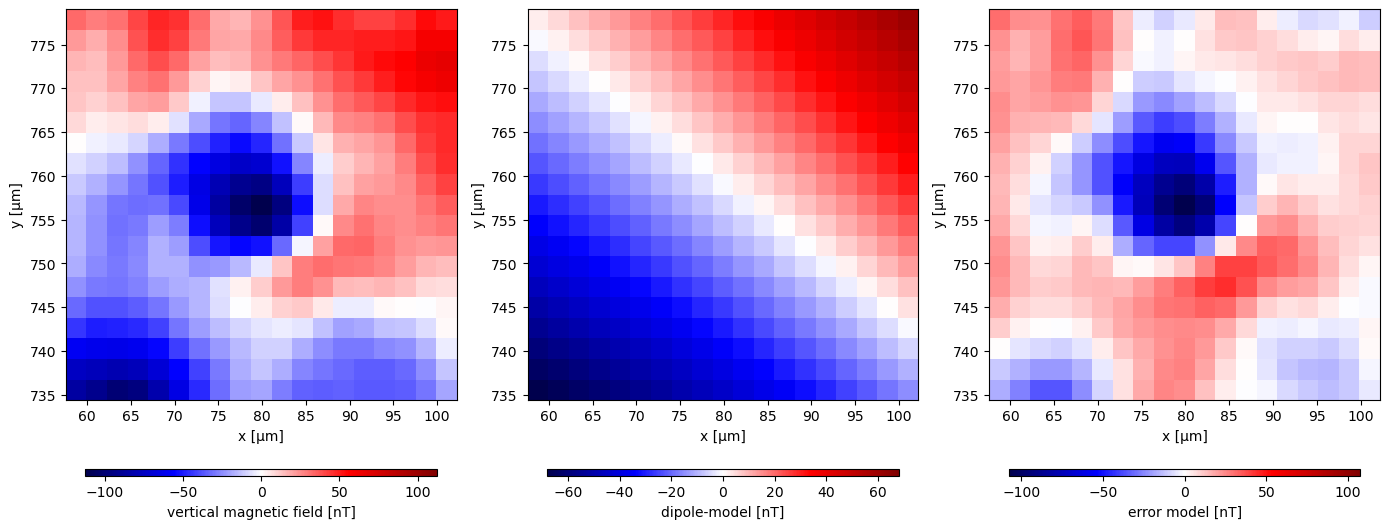

R²: 0.5149126732085941 and SNR: 3.141800730490449


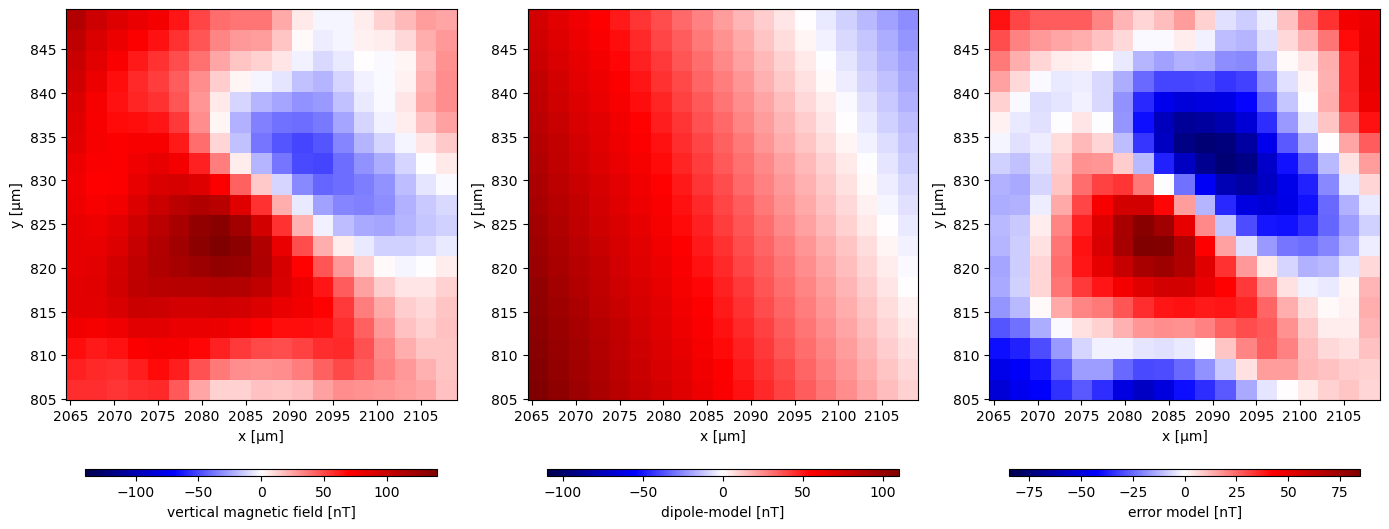

In [120]:
for window, position in zip(windows, positions.T):
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.bz, position,
    )
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    print("R²: %s and SNR: %s"%(r2,SNR))
    
    # calculate model
    coord_slice = vd.grid_coordinates(
    region=[(anomaly.x.values).min(), (anomaly.x.values).max(), (anomaly.y.values).min(), (anomaly.y.values).max()],  # µm
    shape=anomaly.bz.shape,  # µm
    extra_coords=(anomaly.z.values).mean()
    )   
    model = mg.dipole_bz(coord_slice, position, moment)
    

    anomaly = anomaly.assign(model=(['y','x'], model))
    anomaly.model.attrs = {"long_name": "dipole-model", "units": "nT"}

    error = anomaly.bz.values - anomaly.model.values
    anomaly = anomaly.assign(error=(['y','x'],error))
    anomaly.error.attrs = {"long_name": "error model", "units": "nT"}
    
    # plot
    fig, axes = plt.subplots(1, 3, figsize=(14, 14))
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.9)
    for field, ax in zip(["bz", "model", "error"], axes.ravel()):
        
        anomaly[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    
    for ax in axes.ravel():
        ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()